##Note for documentation
1. The adding of a damping term for the seasonality
2. Whether to optimize the value of lambda ?
3. whether to transform the data ?
4. Whether to perform the backward and forward run ?
5. The reasoning behind the seasonality effects on the simulation data.

In [5]:
def get_simulation_structure(Commodities_L1_number = 1,Departments_L1_number =1,Account_level_number=3,Suppliers_number = 4):

    import numpy as np
    import pandas as pd
    from datetime import datetime, timedelta
    import math

    if Commodities_L1_number <1 or Commodities_L1_number >7:
        raise ValueError('Commodities_L1_number must be between 1 and 7')
    if Departments_L1_number <1 or Departments_L1_number >7:
        raise ValueError('Departments_L1_number must be between 1 and 7')
    if Account_level_number <1 or Account_level_number >6:
        raise ValueError('Account_level_number must be between 1 and 6')
    if Suppliers_number <1 or Suppliers_number >15:
        raise ValueError('Suppliers_number must be between 1 and 15')

    ###########################################
    #... Laying out the structure of data .....
    ###########################################

    # The columns of the desired dataframe.
    columns = ['InvoiceID','Supplier Name','Date','Date(Quarter)',
                'Date(Year)','Invoice Spend','Commodity (enriched) - Custom Category (L1)',
                'Commodity (enriched) - Custom Category (L2)',
                'Commodity (enriched) - Custom Category (L3)','Account',
                'Department (D1)','Department (D2)','Department (D3)']

    # Defining the divisions between the subsequent levels of the categories of ordered materials.
    L1_log = ['L1_1','L1_2','L1_3','L1_4','L1_5','L1_6','L1_7']
    L1_log = L1_log[:Commodities_L1_number]
    L2_log = {item : [item+'_L2_1',item+'_L2_2',item+'_L2_3',item+'_L2_4',item+'_L2_5'] for item in L1_log}
    L3_log = {}
    for items in L2_log.values():
        for item in items:
            L3_log[item] = [item+'_L3_1',item+'_L3_2',item+'_L3_3',item+'_L3_4']

    # Linking each final product to at most two suppliers.
    suppliers = ['Supp1','Supp2','Supp3','Supp4','Supp5','Supp6','Supp7','Supp8','Supp9','Supp10','Supp11','Supp12','Supp13','Supp14','Supp15']
    suppliers = suppliers[:Suppliers_number]
    suppliers_log = {}
    for items in L3_log.values():
        for item in items:
            suppliers_log[item]=[np.random.choice(suppliers),np.random.choice(suppliers)]

    # Defining the divisions between grids and departments
    Account = ['Budget_iterm_1','Budget_iterm_2','Budget_iterm_3','Budget_iterm_4','Budget_iterm_5','Budget_iterm_6']
    Account = Account[:Account_level_number]

    # Defining the divisions between the subsequent levels of the departments.
    D1_log = ['D1_1','D1_2','D1_3','D1_4','D1_5','D1_6','D1_7']
    D1_log = D1_log[:Departments_L1_number]
    D2_log = {item : [item+'_D2_1',item+'_D2_2',item+'_D2_3',item+'_D2_4',item+'_D2_5'] for item in D1_log}
    D3_log = {}
    for items in D2_log.values():
        for item in items:
            D3_log[item] = [item+'_D3_1',item+'_D3_2',item+'_D3_3',item+'_D3_4']
    return {'columns':columns,'L1_log':L1_log,'L2_log':L2_log,'L3_log':L3_log,'suppliers':suppliers,
            'Account':Account,'D1_log':D1_log,'D2_log':D2_log,'D3_log':D3_log,'suppliers_log':suppliers_log}


    
def insert_entries(simulation_structure,seed,start_year = 2013,end_year = 2023,
                   mu = [500000,1000000],sdv = [50000,100000],rtrend = [25000,50000]):
    import numpy as np
    import pandas as pd
    from datetime import datetime, timedelta
    import math
    import random
    if start_year > end_year:
        raise ValueError('end_year must be after the start year')

    if start_year < 1900:
        raise ValueError('please give a realistic number')
    if end_year > 2025:
        raise ValueError('you might be looking too far into the future')

    columns = simulation_structure['columns']
    L1_log = simulation_structure['L1_log']
    L2_log = simulation_structure['L2_log']
    L3_log = simulation_structure['L3_log']
    suppliers = simulation_structure['suppliers']
    Account = simulation_structure['Account']
    D1_log = simulation_structure['D1_log']
    D2_log = simulation_structure['D2_log']
    D3_log = simulation_structure['D3_log']
    suppliers_log = simulation_structure['suppliers_log']
    # Setting random seeds for reproducibility
    

    ###################################################################
    #.... Inserting the entries to the previously defined struchure ...
    ###################################################################

    # Calculate the number of days between start_date and end_date
    start_date = datetime(start_year, 9, 1)
    end_date = datetime(end_year, 12, 31)
    delta = (end_date - start_date).days

    # Creating an empty dataframe to fill it later with entries
    df = pd.DataFrame(columns=columns)
    behavior = {}
    # Looping through each department and inserting all of its entries at once

    # Looping through each department level by level
    for D1 in D1_log:
        for D2 in D2_log[D1]:
            for D3 in D3_log[D2]:
                # Each department should have a distinct bahavior (distribution)
                mean = np.abs(random.randint(mu[0],mu[1]))
                std_dev = np.abs(random.randint(sdv[0],sdv[1]))
                samples = np.abs(np.random.normal(mean, std_dev, 3000)) # not all of those will be used        

                # Calculate the intervals between the invoices
                # Assuming the time to event is exponential with random rate
                #   time to event is reasonably between one day to one week
                random_rate = np.abs(random.randint(1,7)) # pick a random parameter for this department
                random_days = np.abs(np.random.exponential(random_rate,3000)) # use the parameter to draw samples
                comulative_sum = np.abs(np.cumsum(random_days))

                # Keeping only the dates that fall within the studied period (2013-2023)
                selected_dates = [int(date) for date in comulative_sum if date < delta ]
                
                # Deciding on the number of entries for this department
                entries = len(selected_dates)

                # Deciding on a trend for this department's time series:

                random_trend = random.randint(rtrend[0],rtrend[1])

                # Having a list of 12 seasonal effects , one effect for each months.
                highest_point_of_season = np.random.uniform(0.1,0.9)
                lowest_point_of_season = np.random.uniform(0.1,highest_point_of_season)
                first_half = [lowest_point_of_season + (i+1)*((highest_point_of_season - lowest_point_of_season)/6) for i in range(6)]
                second_half = [highest_point_of_season - (i+1)*((highest_point_of_season - lowest_point_of_season)/6) for i in range(6)]
                seasonal_effects = []
                for x in range(12):
                    if x in range(0,6):
                        seasonal_effects.append(first_half[x])
                    if x in range(6,12):
                        seasonal_effects.append(second_half[x-6])
                seasonal_effects = [round(x*(1/min(seasonal_effects)),4) for x in seasonal_effects]
                

                # Keeping log of each department's behavior
                behavior[D3] = {'mean':mean,'std_dev':std_dev,'random_rate':random_rate,
                                'random_trend':random_trend,'seasonal_effects':seasonal_effects}



                # Entring one entry in each iteration
                for i in range(entries):

                    # Picking a L3 commodity
                    random_L1 = np.random.choice(L1_log)
                    random_L2 = np.random.choice(L2_log[random_L1])
                    random_L3 = np.random.choice(L3_log[random_L2])

                    # Picking a value to be the base level of this entry
                    value = samples[i]

                    # Selecting the trend
                    trend = random_trend*i

                    # Finalizing the value to be inserted after adding the trend
                    value = value + trend

                    

                    # Picking a date
                    random_date = start_date + timedelta(days=selected_dates[i])
                    
                    # Applying the seasonality
                    month_index = random_date.date().month
                    selected_seasonal_effect = seasonal_effects[month_index-1]
                    value = value*selected_seasonal_effect

                    # Inserting the entry
                    df.loc[df.shape[0],:] = [df.shape[0],np.random.choice(suppliers_log[random_L3]),random_date.date(),math.ceil(random_date.date().month/3),
                                            random_date.date().year,round(value,0),random_L1,random_L2,random_L3,np.random.choice(Account),D1,D2,D3]

                
    # Checking the dimensions of the resulting dataframe
    print('The dimensions (n-rows , n-columns) of the simulated dataframe are:  ',df.shape)
    D3_behavior = pd.DataFrame.from_dict(behavior,orient='index')

    return {'behavior':behavior,'df':df,'simulation_structure':simulation_structure,'suppliers_log':suppliers_log}


def insert_anomalies(entries_object,seed ,number_of_anomalies = 20):
    import numpy as np
    import pandas as pd
    from datetime import datetime, timedelta
    import math
    import random
    simulation_structure = entries_object['simulation_structure']
    columns = simulation_structure['columns']
    L1_log = simulation_structure['L1_log']
    L2_log = simulation_structure['L2_log']
    L3_log = simulation_structure['L3_log']
    suppliers = simulation_structure['suppliers']
    Account = simulation_structure['Account']
    D1_log = simulation_structure['D1_log']
    D2_log = simulation_structure['D2_log']
    D3_log = simulation_structure['D3_log']
    suppliers_log = entries_object['suppliers_log']

    df = entries_object['df']
    if number_of_anomalies > df.shape[0]:
        raise ValueError('There will be more anomalies than entries')
    behavior = entries_object['behavior']
    ##########################################
    # ... Adding the anomalies to the data ...
    ##########################################

    # Keeping log of produced anomalies
    anomalies_log = pd.DataFrame(columns=['invoice_ID','department_D3','anomaly type','old_value','new_value',
                                        'old_rate','new_rate','affected entries','iso/patchy/shift'])
    number_of_inserted_anomalies = 0
    affected_entities = []
    deleted_indecies = []
    number_of_anomalies = number_of_anomalies
    
    '''
    {'mean':mean,'std_dev':std_dev,'random_rate':random_rate,
                                'random_trend':random_trend,'seasonal_effects':seasonal_effects}
    '''

    while number_of_inserted_anomalies != number_of_anomalies:
        i = number_of_inserted_anomalies

        # Anomaly could be produced either by manipulating value or frequency
        pick = np.random.choice(['extremely higher value','higher value','lower value'])#,'patchy higher','patchy lower'])
        #,'lower frequency','higher frequency'])
        #'patchy higher','patchy lower','level shift lower','level shift higher']) 
        # 'aggregate increase' is taken out ,'lower frequency','higher frequency'

        if pick == 'higher value':
            #affected_entities = []
            # Produce an anomaly by manipulating one value to be abnormally high
            # getting random index
            random_index = random.randint(0,df.shape[0]-1)
            if int(random_index) in deleted_indecies:
                continue
            department = df.loc[random_index,'Department (D3)']
            if department in affected_entities:
                continue
            affected_entities.append(department)
            old_invoice = df.loc[random_index,'Invoice Spend']
            selected_behavior = behavior[department]
            std_dev = selected_behavior['std_dev']

            # Modifying the value to become 7*sigma which is associated with an anomaly
            anomalous_value = old_invoice + 7*std_dev
            df.loc[random_index,'Invoice Spend'] = anomalous_value

            # Keeping a log of all anomalies
            anomalies_log.loc[anomalies_log.shape[0],:] = [random_index,department,'higher value',int(old_invoice),int(anomalous_value),
                                                        int(selected_behavior['random_rate']),int(selected_behavior['random_rate']),
                                                        '-','isolated outliers']
            number_of_inserted_anomalies = number_of_inserted_anomalies + 1

        elif pick == 'extremely higher value':
            #affected_entities = []
            # Produce an anomaly by manipulating one value to be abnormally high
            # getting random index
            random_index = random.randint(0,df.shape[0]-1)
            if int(random_index) in deleted_indecies:
                continue
            department = df.loc[random_index,'Department (D3)']
            if department in affected_entities:
                continue
            affected_entities.append(department)
            old_invoice = df.loc[random_index,'Invoice Spend']
            selected_behavior = behavior[department]
            std_dev = selected_behavior['std_dev']

            # Modifying the value to become 7*sigma which is associated with an anomaly
            anomalous_value = old_invoice *15
            df.loc[random_index,'Invoice Spend'] = anomalous_value

            # Keeping a log of all anomalies
            anomalies_log.loc[anomalies_log.shape[0],:] = [random_index,department,'extremely higher value',int(old_invoice),int(anomalous_value),
                                                        int(selected_behavior['random_rate']),int(selected_behavior['random_rate']),
                                                        '-','isolated outliers']
            number_of_inserted_anomalies = number_of_inserted_anomalies + 1


        elif pick == 'aggregate increase':
            # Manipluating the frequency of invoices to be abnormally low
            # getting random index
            random_index = random.randint(0,df.shape[0]-1)
            if int(random_index) in deleted_indecies:
                continue
            department = df.loc[random_index,'Department (D3)']
            commodity = df.loc[random_index,'Commodity (enriched) - Custom Category (L3)']
            if commodity in affected_entities:
                continue
            affected_entities.append(commodity)
            old_invoice = df.loc[random_index,'Invoice Spend']
            selected_behavior = behavior[department]
            std_dev = selected_behavior['std_dev']

            anomalous_interval = random.randint(30,90)
            original_date = df.loc[random_index,'Date']
            new_date = original_date + pd.Timedelta(days=anomalous_interval)

            entries_to_increase = df[(df['Commodity (enriched) - Custom Category (L3)']== commodity) & (df['Date']> original_date) & (df['Date']< new_date)]
            indecies_to_increase = entries_to_increase['InvoiceID']

            # Shifting the values of the following entries
            value_for_log = int()
            for p in indecies_to_increase:
                old_value = df.loc[p,'Invoice Spend']
                new_value = 2*old_value
                df.loc[p,'Invoice Spend'] = new_value
                if p == random_index:
                    value_for_log = new_value


            # Keeping a log of all anomalies
            anomalies_log.loc[anomalies_log.shape[0],:] = [random_index,commodity,'aggregate increase',int(old_invoice),int(old_invoice),
                                                        int(selected_behavior['random_rate']),int(selected_behavior['random_rate']),
                                                        f'slightly increasing {len(indecies_to_increase)} entries','shift']
            number_of_inserted_anomalies = number_of_inserted_anomalies + 1


        elif pick == 'lower value':
            #affected_entities = []
            # Produce an anomaly by manipulating the value to be abnormally low
            # getting random index
            random_index = random.randint(0,df.shape[0]-1)
            if int(random_index) in deleted_indecies:
                continue
            department = df.loc[random_index,'Department (D3)']
            if department in affected_entities:
                continue
            affected_entities.append(department)
            old_invoice = df.loc[random_index,'Invoice Spend']
            selected_behavior = behavior[department]
            std_dev = selected_behavior['std_dev']

            # Modifying the value to become |old_value - 7xsd| which is associated with an anomaly
            #   this, however, might not be easily detected because there are no negative invoices (bounded from below)
            anomalous_value = old_invoice*0.1
            df.loc[random_index,'Invoice Spend'] = anomalous_value

            # Keeping a log of all anomalies
            anomalies_log.loc[anomalies_log.shape[0],:] = [random_index,department,'lower value',int(old_invoice),int(anomalous_value),
                                                        int(selected_behavior['random_rate']),int(selected_behavior['random_rate']),
                                                        '-','isolated outliers']
            number_of_inserted_anomalies = number_of_inserted_anomalies + 1

        elif pick == 'lower frequency':
            # Manipluating the frequency of invoices to be abnormally low
            # getting random index
            random_index = random.randint(0,df.shape[0]-1)
            if int(random_index) in deleted_indecies:
                continue
            department = df.loc[random_index,'Department (D3)']
            if department in affected_entities:
                continue
            affected_entities.append(department)
            old_invoice = df.loc[random_index,'Invoice Spend']
            selected_behavior = behavior[department]
            std_dev = selected_behavior['std_dev']

            # Modifying the interval between invoices to become 5*sigma which is associated with an anomaly
            anomalous_rate = selected_behavior['random_rate']+15*selected_behavior['random_rate']
            original_date = df.loc[random_index,'Date']
            new_date = original_date + pd.Timedelta(days=anomalous_rate)

            # Selecting all entries that lie within the range that should be skipped
            entries_to_delete = df[(df['Department (D3)']== department) & (df['Date']> original_date) & (df['Date']< new_date)]
            indecies_to_delete = entries_to_delete['InvoiceID']
            deleted_indecies.append([int(i) for i in indecies_to_delete])

            # Deleting them leaving behind anomalous gap
            df = df.drop(indecies_to_delete)

            # Keeping a log of all anomalies
            anomalies_log.loc[anomalies_log.shape[0],:] = [random_index,department,'lower frequency',int(old_invoice),int(old_invoice),
                                                        int(selected_behavior['random_rate']),int(anomalous_rate),
                                                        f'deleting {len(indecies_to_delete)} entries','-']
            number_of_inserted_anomalies = number_of_inserted_anomalies + 1

        elif pick == 'higher frequency':
            # Manipluating the frequency of invoices to be abnormally high
            # getting random index
            random_index = random.randint(0,df.shape[0]-1)
            if int(random_index) in deleted_indecies:
                continue
            department = df.loc[random_index,'Department (D3)']
            if department in affected_entities:
                continue
            affected_entities.append(department)
            old_invoice = df.loc[random_index,'Invoice Spend']
            department_1 = df.loc[random_index,'Department (D1)']
            department_2 = df.loc[random_index,'Department (D2)']

            selected_behavior = behavior[department]
            std_dev = selected_behavior['std_dev']

            # Modifying the interval between invoices to become sigma/7 which is associated with an anomaly
            anomalous_rate = selected_behavior['random_rate']/15
            original_date = df.loc[random_index,'Date']
            anomalous_range = random.randint(60,90)


            # In terms of values, we keep the same bahavior.
            mean = selected_behavior['mean']
            std_dev = selected_behavior['std_dev']
            trend = selected_behavior['random_trend']
            seasonal_effects = selected_behavior['seasonal_effects']
            samples = np.abs(np.random.normal(old_invoice, std_dev, 3000))

            # Calculate the anomalous dates
            # Assuming the time to event is exponential with random rate
            random_days = np.random.exponential(anomalous_rate,3000)
            comulative_sum = np.cumsum(random_days)

            # Selecting only the dates within the anomalous range
            selected_dates = [int(date) for date in comulative_sum if date < anomalous_range ]
            
            # Deciding on the number of added entries for this anlmalous department
            entries = len(selected_dates)

            # Entring one entry through each iteration
            for j in range(entries):

                # Picking an item
                random_L1 = np.random.choice(L1_log)
                random_L2 = np.random.choice(L2_log[random_L1])
                random_L3 = np.random.choice(L3_log[random_L2])

                # Picking a value
                value = samples[j]

                # Applying trend
                value = value + trend*j

                # Picking a date
                start_date = original_date
                random_date = start_date + timedelta(days=selected_dates[j])

                month_index = random_date.month
                selected_seasonal_effect = seasonal_effects[month_index-1]
                value = value * selected_seasonal_effect

                # Inserting the entry
                df.loc[df.shape[0],:] = [df.shape[0],np.random.choice(suppliers_log[random_L3]),random_date,
                                        math.ceil(random_date.month/3),random_date.year,round(value,0),random_L1,
                                        random_L2,random_L3,np.random.choice(Account),department_1,department_2,department]
                
                
            
            # Keeping a log of all anomalies
            anomalies_log.loc[anomalies_log.shape[0],:] = [random_index,department,'higher frequency',int(old_invoice),int(old_invoice),
                                                        int(selected_behavior['random_rate']),int(anomalous_rate),f'adding {entries} entries','-']
            number_of_inserted_anomalies = number_of_inserted_anomalies + 1


        elif (pick == 'patchy higher') | (pick == 'patchy lower'):
            #affected_entities = []
            # getting random index to start the patchy outlier effect.
            random_index = random.randint(0,df.shape[0]-1)     
            if int(random_index) in deleted_indecies:
                continue    
            department = df.loc[random_index,'Department (D3)']
            if department in affected_entities:
                continue
            affected_entities.append(department)
            original_date = df.loc[random_index,'Date']
            selected_behavior = behavior[department]
            std_dev = selected_behavior['std_dev']
            seasonal_effects = selected_behavior['seasonal_effects']
            patchy_size = random.randint(2,10)

            # Selecting indecies that are affected by the patchy effect.
            entries_to_change = df[(df['Department (D3)']== department) & (df['Date']>= original_date)]
            indecies_to_change = entries_to_change.index[0:patchy_size]

            if pick == 'patchy higher':
                for indx in indecies_to_change:
                    dep = df.loc[indx,'Department (D3)']
                    old_val = df.loc[indx,'Invoice Spend']
                    anomalous_val = int(old_val+std_dev*7)
                    error = np.random.uniform(anomalous_val/20,anomalous_val/18)
                    anomalous_val = anomalous_val +error

                    
                    df.loc[indx,'Invoice Spend'] = anomalous_val
                # Keeping a log of all anomalies
                anomalies_log.loc[anomalies_log.shape[0],:] = [random_index,department,'patchy higher',int(old_val),int(anomalous_val),
                                                            int(selected_behavior['random_rate']),int(selected_behavior['random_rate']),
                                                            f'increased {patchy_size} consequtive entries','patchy outliers']
                number_of_inserted_anomalies = number_of_inserted_anomalies + 1

            if pick == 'patchy lower':
                for indx in indecies_to_change:
                    dep = df.loc[indx,'Department (D3)']
                    old_val = df.loc[indx,'Invoice Spend']
                    anomalous_val = int(0.1*old_val )
                    error = np.random.uniform(anomalous_val/30,anomalous_val/28)
                    anomalous_val = anomalous_val +error
                    
                    df.loc[indx,'Invoice Spend'] = anomalous_val
                # Keeping a log of all anomalies
                anomalies_log.loc[anomalies_log.shape[0],:] = [random_index,department,'patchy lower',int(old_val),int(anomalous_val),
                                                            int(selected_behavior['random_rate']),int(selected_behavior['random_rate']),
                                                            f'decreased {patchy_size} consequtive entries','patchy outliers']
                number_of_inserted_anomalies = number_of_inserted_anomalies + 1

            ''' 
            behavior[D3] = {'mean':mean,'std_dev':std_dev,'random_rate':random_rate,
                    'random_trend':random_trend,'seasonal_effects':seasonal_effects}
            '''

        if pick == 'level shift lower':
            #affected_entities = []
            # Manipluating the level of invoices to be abnormally low and stay low for one department at a time
            # getting random index
            random_index = random.randint(0,df.shape[0]-1)
            if int(random_index) in deleted_indecies:
                continue
            department = df.loc[random_index,'Department (D3)']
            if department in affected_entities:
                continue
            affected_entities.append(department)
            old_invoice = df.loc[random_index,'Invoice Spend']
            selected_behavior = behavior[department]
            std_dev = selected_behavior['std_dev']

            # Modifying the value of following invoices to become shifted downwards which is associated with an anomaly
            
            original_date = df.loc[random_index,'Date']

            # Selecting all entries follow the selected one for the same department
            entries_to_shift = df[(df['Department (D3)']== department) & (df['Date']>= original_date)]
            indecies_to_shift = entries_to_shift['InvoiceID']

            # Shifting the values of the following entries
            value_for_log = int()
            for p in indecies_to_shift:
                old_value = df.loc[p,'Invoice Spend']
                new_value = 0.1*old_value
                df.loc[p,'Invoice Spend'] = new_value
                if p == random_index:
                    value_for_log = new_value

            # Keeping a log of all anomalies
            anomalies_log.loc[anomalies_log.shape[0],:] = [random_index,department,'level shift lower',int(old_invoice),
                                                        int(value_for_log),int(selected_behavior['random_rate']),
                                                        int(selected_behavior['random_rate']),
                                                        f'shifting {len(indecies_to_shift)} entries downwards','shift']
            number_of_inserted_anomalies = number_of_inserted_anomalies + 1

        if pick == 'level shift higher':
            #affected_entities = []
            # Manipluating the level of invoices to be abnormally high and stay low for one department at a time
            # getting random index
            random_index = random.randint(0,df.shape[0]-1)
            if int(random_index) in deleted_indecies:
                continue
            department = df.loc[random_index,'Department (D3)']
            if department in affected_entities:
                continue
            affected_entities.append(department)
            old_invoice = df.loc[random_index,'Invoice Spend']
            selected_behavior = behavior[department]
            std_dev = selected_behavior['std_dev']

            # Modifying the value of following invoices to become shifted upwards which is associated with an anomaly
            
            original_date = df.loc[random_index,'Date']

            # Selecting all entries follow the selected one for the same department
            entries_to_shift = df[(df['Department (D3)']== department) & (df['Date']>= original_date)]
            indecies_to_shift = entries_to_shift['InvoiceID']

            # Shifting the values of the following entries
            value_for_log = int()
            for p in indecies_to_shift:
                old_value = df.loc[p,'Invoice Spend']
                new_value = old_value + 7*std_dev
                df.loc[p,'Invoice Spend'] = new_value
                if p == random_index:
                    value_for_log = new_value

            # Keeping a log of all anomalies
            anomalies_log.loc[anomalies_log.shape[0],:] = [random_index,department,'level shift higher',int(old_invoice),
                                                        int(value_for_log),int(selected_behavior['random_rate']),
                                                        int(selected_behavior['random_rate']),
                                                        f'shifting {len(indecies_to_shift)} entries upwards','shift']
            number_of_inserted_anomalies = number_of_inserted_anomalies + 1

    # Reordering the data based on the date
    df['Date'] = pd.to_datetime(df['Date'])
    df_sorted = df.sort_values(by='Date')
    
    
    return {'df_sorted':df_sorted,'anomalies_log':anomalies_log}



def save_data_anomalies_to_file(anomalous_data_object ,
                                path ='Ashraf/data_simulation/',
                                data_name_str = 'dummy.xlsx',anomalies_log_str = 'anomalies_log.xlsx' ):
    
    #if path[:62] != '/Workspace/Users/ashraf.zedane@nl.abnamro.com/data_simulation/':
    #    raise ValueError('The path to save the data must be in "/Workspace/Users/ashraf.zedane@nl.abnamro.com/data_simulation/" ')

    df_sorted = anomalous_data_object['df_sorted']
    anomalies_log = anomalous_data_object['anomalies_log']
    ###########################
    # ... Exporting to excel...
    ###########################

    path_data  = str(path) + str(data_name_str)
    df_sorted.to_excel(path_data, index=False)

    print('files have been saved to the following location')
    print(path_data)


    path_anomalies_log  = str(path) + str(anomalies_log_str)
    anomalies_log.to_excel(path_anomalies_log,index=True)

    print('files have been saved to the following location')
    print(path_anomalies_log)

def simulate_data(seed,
                  Commodities_L1_number = 1,
                  Departments_L1_number = 1,
                  Account_level_number = 3,
                  Suppliers_number = 4,
                  start_year = 2013,
                  end_year = 2023,
                  number_of_anomalies = 250,
                  path ='Ashraf/data_simulation/Reduced_data/',
                  data_name_str = 'dummy.xlsx',
                  anomalies_log_str = 'anomalies_log.xlsx',
                  mu = [500000,1000000],sdv = [50000,100000],
                  rtrend = [25000,50000]):
    import numpy as np
    import pandas as pd
    from datetime import datetime, timedelta
    import math

    simulation_structure = get_simulation_structure(Commodities_L1_number = Commodities_L1_number,
                                                    Departments_L1_number =Departments_L1_number,
                                                    Account_level_number=Account_level_number,
                                                    Suppliers_number = Suppliers_number)

    entries_object = insert_entries(simulation_structure=simulation_structure,
                                    start_year = start_year,end_year = end_year,
                                    mu = mu ,sdv = sdv,seed = seed)

    anomalous_data_object = insert_anomalies(entries_object = entries_object,number_of_anomalies = number_of_anomalies,seed = seed)
    df_sorted = anomalous_data_object['df_sorted']
    anomalies_log = anomalous_data_object['anomalies_log']
    print('done!')
    return {'df_sorted':df_sorted,
            'anomalies_log':anomalies_log}

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math
import statistics
from scipy.optimize import minimize
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings

np.random.seed(1)
# Return sign        
def sign(x):
   """A function that returns the signal of a number.

    Args:
        x: the number whose signal is wanted

    Returns:
        int: either -1 or 1 depending on x's signal

    Usage:
        sign(15) = 1
    """
   return int(math.copysign(1, x))


# Huber function to limit the effect of extreme values:
def huber(x,k_huber=3):
    """A function that prevents observations from having unbounded values.

    This function imposes a ceiling on values, ensuring they do not exceed a specified threshold.

    Args:
    x: The number that is under study.
    k_huber: The ceiling value.

    Returns:
    float: A value that follows the given number but never exceeds the ceiling.

    Usage:
    huber(5, k_huber=3) = 3
    """

    k_huber = 3
    if abs(x)<k_huber:
        return x
    else:
        return sign(x)*k_huber


# Biweight function
def get_biweight(x,ck,k):
    """A function that is used to assign weights based on a distance measure.

    The values of the constants ck and k describe how the assigned weight changes.

    Args:
        x: The number for which the weight is calculated.
        ck: A constant that influences the weight.
        k: A constant that determines the range of influence.

    Returns:
        float: The weight that the number should carry.

    Usage:
        get_biweight(-2, ck=5, k=1.75) = 5
    """
    if abs(x)<k:
        return ck*(1-(1-(x/k)**2)**3)
    else:
        return ck


# Estimating sigma_hat from the privious sigma
def get_sigma_hat(k,ck,previous_sigma,observed,predicted,lmbda,integers,min_dif,multiplicative_error=True):
    """Estimates sigma_hat on each step by taking previous sigma into account, in addition to the observed and predicted values.

    The parameter lmbda is the smoothing parameter, estimated through the optimization process. 
    Based on whether the error is multiplicative or additive, calculations are different.

    Args:
        k: Constant affecting the get_biweight() function.
        ck: Constant affecting the get_biweight() function.
        previous_sigma: The previous value of sigma.
        observed: The observed value.
        predicted: The predicted value.
        lmbda: The smoothing parameter.
        integers: Boolean indicating if the data is integer-valued.
        min_dif: Minimum difference to avoid division by zero.
        multiplicative_error: Boolean indicating if the error is multiplicative.

    Returns:
        float: An estimate of the current sigma.

    Usage:
        get_sigma_hat(k=1.75, ck=5, previous_sigma=0.5, observed=1e4, predicted=9e3, lmbda=0.2, 
                      multiplicative_error=True, integers=False, mid_dif = 0.01) = 0.46032
    """
    # To avoid division on zero, especially when dealing with anomalous values.
    epsilon = 1e-8

    # The possibility of setting a minimum value for sigma
    if integers:
      epsilon_sigma = min_dif
    else:
      epsilon_sigma = 0

    # Overwrite min_dif value. The restriction will be set on the initial sigma_0
    epsilon_sigma = 0

    if multiplicative_error:
      sigma_hat_squared = lmbda * get_biweight((observed-predicted)/(predicted * previous_sigma+epsilon),ck=ck,k=k) * (previous_sigma)**2 + (1-lmbda) * (previous_sigma)**2

      # In case of an error, to understand the circumstances
      if sigma_hat_squared<0:
         print('Negative value: ',sigma_hat_squared,'\n',
               'lmbda: ',lmbda,' previous_sigma: ',previous_sigma,'\n',
               'observed: ',observed,' .predicted: ',predicted,'\n',
               'get_biweight: ',get_biweight((observed-predicted)/(predicted * previous_sigma+epsilon),ck=ck,k=k),'\n')
      sigma_hat = math.sqrt(sigma_hat_squared)

      # Possibly setting a minimum sigma value if epsilon_sigma!=0
      return max(sigma_hat,epsilon_sigma)
    
    # Additive error case   
    else:
      sigma_hat_squared = lmbda * get_biweight((observed-predicted)/(previous_sigma+epsilon),ck = ck,k=k) * (previous_sigma)**2 + (1-lmbda) * (previous_sigma)**2
      
      # in case of an error
      if sigma_hat_squared<0:
         print('Negative value: ',sigma_hat_squared,'\n',
               'lmbda: ',lmbda,' previous_sigma: ',previous_sigma,'\n',
               'observed: ',observed,' .predicted: ',predicted,'\n',
               'get_biweight: ',get_biweight((observed-predicted)/(predicted * previous_sigma+epsilon),ck=ck,k=k),'\n')
      sigma_hat = math.sqrt(sigma_hat_squared)

      # Possibly setting a minimum sigma value if epsilon_sigma!=0
      return max(sigma_hat,epsilon_sigma)
   




# Clean observations:
def get_clean_observation(k,observed ,predicted, sigma_hat,multiplicative_error=True):
    """Clean observations are observations whose values are adjusted to limit the influence of extreme data points.

    Observed values and predictions, in addition to sigma_hat, are necessary to set the threshold of where to start "cleaning".
    The clean observations are the ones used to obtain the predicted values for the time series and not the actual observations.

    Args:
        k: Constant affecting the huber() function.
        observed: The observed value.
        predicted: The predicted value.
        sigma_hat: The estimated sigma value.
        multiplicative_error: Boolean indicating if the error is multiplicative.

    Returns:
        float: An adjusted observation if its value is extreme, otherwise the same as the actual observation.

    Usage:
        get_clean_observation(k=1.75, observed=1e4, predicted=9e3, sigma_hat=0.54, multiplicative_error=True) = 9999.9999
    """
    # To avoid division on zero when dealing with anomalies
    epsilon = 1e-8
    if multiplicative_error:
      clean_observation = (1+ huber((observed-predicted)/(predicted*sigma_hat+epsilon))*sigma_hat)*predicted
      return clean_observation
    else:
      clean_observation = huber((observed-predicted)/(sigma_hat+epsilon))*sigma_hat + predicted
      return clean_observation
   


# MAD Median Absolute Deviance
def get_MAD(errors):
  """This is an alternative to the mean() for when doing robust calculations against outliers.

  Because outliers can have a greater effect on means, medians represent a much more robust alternative.

  Args:
      errors: A list of errors. If errors are additive, it's the difference between observed and predicted values.
              If errors are multiplicative, it's the ratio between observed and predicted values.

  Returns:
      float: The Median Absolute Deviation (MAD).

  Usage:
      get_MAD([3,6,3,1,34,2]) = 2.2239
  """

  # Calculate the absolute deviations from the median
  med = np.median(errors)
  absolute_error = np.abs(errors-med)
  # Calculate the MAD
  MAD = 1.4826 * np.median(absolute_error)
  # Trying possibly: setting a minimum on the MAD value which is not 0
  #MAD = max(MAD,get_min_pairwise_differences(absolute_error))
  return MAD




def get_t_tilde(t, m):
  """To compute the right moment of the seasonal cycle.

  This function calculates the position of an observation within the seasonal cycle.

  Args:
      t: The index of the observation.
      m: The length of one season.

  Returns:
      int: The position of the observation in the seasonal cycle.

  Usage:
      get_t_tilde(401, 12) = 5
  """

  t_tilde = (t % m)
  return t_tilde




def tau_squared(e,ck,k):
   """A robust alternative to the sum of squares.

   This function is used in the target function of the optimization process to calculate how distant the observations 
   are from a supposed center, which is the Median Absolute Deviation (MAD).

   Args:
       e: A list of errors. If errors are additive, it's the difference between observed and predicted values.
          If errors are multiplicative, it's the ratio between observed and predicted values.
       ck: A constant influencing the weight calculation.
       k: A constant determining the range of influence.

   Returns:
       float: The quantity of tau^2.

   Usage:
       tau_squared([3,6,3,1,34,2], ck=5, k=1.75) = 19.17745
   """

   # To avoid division on zero especially when dealing with anomalous values
   epsilon = 1e-6
   s_T = get_MAD(e)
   ck=5
   k=1.75
   TT = len(e)
   ratio  = (s_T**2/TT)
   summ = 0
   
   for i in range(len(e)):
      x=e[i]/(s_T+epsilon)
      summ = summ + get_biweight((e[i]/(s_T+epsilon)),ck=ck,k=k)
   tau_2 = ratio * summ

   # In case of an error
   if tau_2<0:
      print('Negative tau_squared value encountered', tau_2)
      raise ValueError('Negative tau_squared value encountered')
   # In case of an error
   if tau_2 == 0:
      print(tau_2, ' = 0 encountered','s_T: ',s_T,' | ck: ',ck,' | k:',k,' | TT:',TT,' | ratio: ',ratio,' | summ: ',summ)
      print('The e vector that led to the error: ',e)
      print('The np.median(errors) vector that led to the error: ',np.median(e))
      print('The np.abs(errors-np.median(errors)) vector that led to the error: ',np.abs(e-np.median(e)))
      print('The 1.4826 * np.median(np.abs(errors-np.median(errors))) vector that led to the error: ',1.4826 * np.median(np.abs(e-np.median(e))))
      print('get_min_pairwise_differences(e): ',get_min_pairwise_differences(e))
   return tau_2




def rob_lik_A (observed,predicted,ck,k):
   """Getting the robust likelihood for the additive error case.

   This function utilizes the tau_squared() function to compute the robust likelihood.

   Args:
       observed: The observed values.
       predicted: The predicted values.
       ck: A constant influencing the weight calculation.
       k: A constant determining the range of influence.

   Returns:
       float: The robust likelihood for the additive error case.

   Usage:
       rob_lik_A(observed=np.array([10, 19, 20]), predicted=np.array([1, 14, 19]), ck=5, k=1.75) = -6.77312
   """

   e = observed - predicted
   TT = len(e)
   tau2 = tau_squared(e,ck=ck,k=k)
   if tau2<0:
      print('Encountered a negative value of tau_squared',tau2)
   roblik_A = (-TT/2) * math.log(tau2)
   return roblik_A


def get_multiplicative_error(observed,predicted):
   """For the multiplicative case, errors are not the difference between observed and predicted.

   Here, the error is the ratio between the difference and the predicted value.

   Args:
       observed: The observed values.
       predicted: The predicted values.

   Returns:
       np.ndarray: The calculated multiplicative errors.

   Usage:
       get_multiplicative_error(observed=[10, 15, 20], predicted=[9, 14, 19]) = array([0.11111111, 0.07142857, 0.05263158])
   """

   epsilon = 1e-8
   e = np.zeros(len(observed))
   for i in range(len(observed)):
    e[i] = (observed[i]-predicted[i])/(predicted[i]+epsilon)
   return e


def rob_lik_M(observed,predicted,ck,k):
   """Calculating the robust likelihood for the multiplicative case.

   This function utilizes the tau_squared() function to compute the robust likelihood for multiplicative errors.

   Args:
       observed: The observed values.
       predicted: The predicted values.
       ck: A constant influencing the weight calculation.
       k: A constant determining the range of influence.

   Returns:
       float: The robust likelihood for the multiplicative error case.

   Usage:
       rob_lik_M(observed=[10, 15, 20], predicted=[9, 14, 19], ck=5, k=1.75) = 8.32662
   """

   e = get_multiplicative_error(observed,predicted)
   TT = len(e)
   tau2 = tau_squared(e,ck=ck,k=k)
   if tau2<0:
      print('Encountered a negative value of tau_squared',tau2)
   roblik_M = (-TT/2) * math.log(tau2)
   return roblik_M


def get_min_pairwise_differences(arr):
   """Returns the non-zero minimum pairwise difference between the values of an array.

   This function calculates the absolute differences between all pairs of elements in the array and finds the minimum non-zero difference.

   Args:
       arr: An array of numerical values.

   Returns:
       float: The minimum non-zero pairwise difference. Returns None if no such difference exists.

   Usage:
       get_min_pairwise_differences([3, 6, 3, 1, 34, 2]) = 1
   """

   differences =  [abs(arr[i]-arr[j]) for i in range(len(arr)) for j in range(i+1,len(arr))]
   arr = np.array(differences)
   filtered_arr = arr[arr != 0]
   return filtered_arr.min() if filtered_arr.size > 0 else None


def get_startup_period(seasonality,y,m):
   """Determines the startup period for obtaining initial values in a time series analysis.

   The startup period is the number of observations at the beginning of the series used to obtain all initial values. 
   It is estimated differently based on whether there is a seasonal component.

   Args:
       seasonality: A boolean indicating the presence of a seasonal component.
       y: The time series data.
       m: The length of one season.

   Returns:
       int: The number of observations in the startup period.

   Usage:
       get_startup_period(seasonality=True, y=[i for i in range(50)], m=3) = 15
   """

   if seasonality :
      startup_period = max(5*m,10)
   else:
      startup_period = 10
   if len(y)<startup_period:
      warnings.warn("There are too few data points to obtain robust starting values.", FutureWarning)
      startup_period = len(y)
   return startup_period


def get_b_0(startup_period,y):
    """Calculates the initial slope estimate (b_0_hat) for a time series.

    This function computes the median of the slopes between all pairs of points in the startup period.

    Args:
    startup_period: The number of observations used to calculate the initial values.
    y: The time series data.

    Returns:
    float: The initial slope estimate (b_0_hat).

    Usage:
    get_b_0(startup_period=10, y=[i for i in range(0,50, 3)]) = 3.0
    """

    # b_0_hat : Getting the median of i for the medians of j
    amounts_i =[]
    for i in range(startup_period):
        amounts_j = []
        for j in range(startup_period):
            if i != j:
                amounts_j.append((y[i]-y[j])/(i-j))
        median_j = statistics.median(amounts_j)
        amounts_i.append(median_j)
    b_0_hat = statistics.median(amounts_i)
    return b_0_hat


def get_l_o(y,startup_period,b_0_hat):
   """Calculates the initial level estimate (L_0_hat) for a time series.

   This function computes the median of the differences between the observed values and the initial slope-adjusted values 
   in the startup period.

   Args:
       y: The time series data.
       startup_period: The number of observations used to calculate the initial values.
       b_0_hat: The initial slope estimate.

   Returns:
       float: The initial level estimate (L_0_hat).

   Usage:
       get_l_o(y=[i for i in range(0,50, 3)], startup_period=10, b_0_hat=0.5) = 11.25
   """

   # L_0_hat :
   startup_observations = y[:startup_period]
   startup_index = range(startup_period)
   l_0_hat = statistics.median([startup_observations[i]-b_0_hat*i for i in startup_index])
   return l_0_hat


def get_s_0(y,multiplicative_seasonality,m,startup_period,b_0_hat,l_0_hat):
   """Calculates the initial seasonal components (S_0) for a time series.

   This function computes the seasonal starting values for all seasons based on whether the seasonality is multiplicative or additive.

   Args:
       y: The time series data.
       multiplicative_seasonality: Boolean indicating if the seasonality is multiplicative.
       m: The length of one season.
       startup_period: The number of observations used to calculate the initial values.
       b_0_hat: The initial slope estimate.
       l_0_hat: The initial level estimate.

   Returns:
       list: The initial seasonal components (S_0).

   Usage:
       get_s_0(y=[i for i in range(0,50, 3)], multiplicative_seasonality=True, m=3, startup_period=10, 
               b_0_hat=0.5, l_0_hat=2.0) = [2.7613 ,2.6666 ,2.999 ]
   """

   # s_0_hat : Getting the seasonal starting values for all seasons
   startup_observations = y[:startup_period]
   startup_index = range(startup_period)
   epsilon = 1e-6 # To avoid deviding by zero


   if multiplicative_seasonality:
      for q in range(m):
         globals()[f'S_{q}'] = []
         for i in range(q, startup_period, m):
            ratio = startup_observations[i] /((startup_index[i]+1)*b_0_hat +l_0_hat+epsilon )
            globals()[f'S_{q}'].append(ratio)
         globals()[f'S_{q}'] = statistics.median(globals()[f'S_{q}'])


   else:
      for q in range(m):
         globals()[f'S_{q}'] = []
         for i in range(q, startup_period, m):
            difference = startup_observations[i] - ((startup_index[i]+1)*b_0_hat +l_0_hat )
            globals()[f'S_{q}'].append(difference)
         globals()[f'S_{q}'] = statistics.median(globals()[f'S_{q}'])


   seasonal_components = [globals()[f'S_{q}'] for q in range(m)]
   return seasonal_components


def get_sigma_0(y,seasonality,multiplicative_error,multiplicative_seasonality,startup_period,m,l_0_hat,b_0_hat,integers,min_dif):
   """Calculates the initial standard deviation estimate (sigma_0_hat) for a time series.

   This function computes the initial sigma value based on the presence of seasonality, error type, and other parameters.

   Args:
       y: The time series data.
       seasonality: Boolean indicating the presence of a seasonal component.
       multiplicative_error: Boolean indicating if the error is multiplicative.
       multiplicative_seasonality: Boolean indicating if the seasonality is multiplicative.
       startup_period: The number of observations used to calculate the initial values.
       m: The length of one season.
       l_0_hat: The initial level estimate.
       b_0_hat: The initial slope estimate.
       integers: Boolean indicating if the data is integer-valued.
       min_dif: Minimum difference to avoid division by zero.

   Returns:
       float: The initial standard deviation estimate (sigma_0_hat).

   Usage:
       get_sigma_0(y=[i for i in range(0,50, 3)], seasonality=True, multiplicative_error=True, 
                   multiplicative_seasonality=False, startup_period=10, m=3, 
                   l_0_hat=2.0, b_0_hat=0.5, integers=False, min_dif=0.01) = 1.43600
   """

   # sigma_0_hat
   startup_observations = y[:startup_period]
   epsilon = 1e-6 # To avoid deviding by zero




   if seasonality:
      if multiplicative_error:
         if not multiplicative_seasonality:
            error_components =[]
            for t in range(startup_period):
               
               t_tilde = get_t_tilde(t=t,m=m)
               called_seasonality = globals()[f'S_{t_tilde}']
               error_components.append((startup_observations[t]-l_0_hat-b_0_hat*(t)-called_seasonality)/(l_0_hat-b_0_hat*(t)-called_seasonality+epsilon))
            sigma_o_hat = get_MAD(error_components)
         else:
            error_components =[]
            for t in range(startup_period):
               
               t_tilde = get_t_tilde(t=t,m=m)
               called_seasonality = globals()[f'S_{t_tilde}']
               error_components.append((startup_observations[t]-(l_0_hat-b_0_hat*(t))/called_seasonality+epsilon)/((l_0_hat-b_0_hat*(t))/called_seasonality+epsilon))
            sigma_o_hat = get_MAD(error_components)


      else:
         if not multiplicative_seasonality:
            error_components =[]
            for t in range(startup_period):
               
               t_tilde = get_t_tilde(t=t,m=m)
               called_seasonality = globals()[f'S_{t_tilde}']
               error_components.append(startup_observations[t]-l_0_hat-b_0_hat*(t)-called_seasonality)
            sigma_o_hat = get_MAD(error_components)
         else:
            error_components =[]
            for t in range(startup_period):
               
               t_tilde = get_t_tilde(t=t,m=m)
               called_seasonality = globals()[f'S_{t_tilde}']
               error_components.append(startup_observations[t]-(l_0_hat-b_0_hat*(t))/called_seasonality+epsilon)
            sigma_o_hat = get_MAD(error_components)
   else :
      error_components =[]
      for t in range(startup_period):
         error_components.append((startup_observations[t]-l_0_hat-b_0_hat*(t))/(l_0_hat-b_0_hat*(t)+epsilon))
      sigma_o_hat = get_MAD(error_components)
   
   if integers:
      epsilon_sigma = get_min_pairwise_differences(error_components)
   else:
      epsilon_sigma = 0
   return max(sigma_o_hat,epsilon_sigma)
   


def get_starting_values(y,min_dif,integers,m=None,trend = True ,seasonality = True,multiplicative_seasonality=True,multiplicative_error=True):
   """Estimates the initial values for the parameters of a time series model.

   Because the process is recursive, choosing the initial values of the parameters matters. This function estimates the initial values in a robust way for the effects (level, trend, seasonality) but not the smoothing parameters.

   Args:
       y: The time series data.
       min_dif: Minimum difference to avoid division by zero.
       integers: Boolean indicating if the data is integer-valued.
       m: The length of one season.
       trend: Boolean indicating if a trend component is present.
       seasonality: Boolean indicating if a seasonal component is present.
       multiplicative_seasonality: Boolean indicating if the seasonality is multiplicative.
       multiplicative_error: Boolean indicating if the error is multiplicative.

   Returns:
       dict: A dictionary containing the initial parameter estimates:
           - l_0_hat: The initial level estimate.
           - b_0_hat: The initial slope estimate.
           - seasonal_components: The initial seasonal components.
           - sigma_o_hat: The initial standard deviation estimate.

   Usage:
       get_starting_values(y=[i for i in range(0,50, 3)], min_dif=0.01, integers=False, m=3, trend=True, 
                           seasonality=True, multiplicative_seasonality=True, multiplicative_error=True) = 
                           {'l_0_hat': 0.0,
                            'b_0_hat': 3.0,
                            'seasonal_components': [0.4615384497041424,
                            0.7142856615646331,
                            0.7999999525925969,
                            0.8437499589843779,
                            0.8705881994002327,
                            0.8333332870370396,
                            0.8571428163265326,
                            0.8749999635416682,
                            0.8888888559670793,
                            0.899999970000001,
                            0.9090908815427007,
                            0.9166666412037044],
                            'sigma_o_hat': 0.06486407566794782}
   """

   


   
   if seasonality and m==None:
      raise ValueError("Please specify the number of seasons, or set seasonality to False")
   if not seasonality and m!=None :
      raise ValueError("Seasonality is set to False and m is provided. Either set seasonality to True or m to None")


   startup_period = get_startup_period(y=y,seasonality=seasonality,m=m)
   if not trend:
      b_0_hat = 0
   else :
      b_0_hat = get_b_0(startup_period=startup_period,y=y)


   l_0_hat = get_l_o(y=y,startup_period=startup_period,b_0_hat=b_0_hat)


   if seasonality:
      seasonal_components = get_s_0(y=y,multiplicative_seasonality=multiplicative_seasonality,m=m,
                              startup_period=startup_period,b_0_hat=b_0_hat,l_0_hat=l_0_hat)
   else :
      if multiplicative_seasonality:
         seasonal_components = 1
      else:
         seasonal_components = 0


   sigma_o_hat = get_sigma_0(y=y,seasonality=seasonality,multiplicative_error=multiplicative_error,multiplicative_seasonality=multiplicative_seasonality,
                             startup_period=startup_period,m=m,l_0_hat=l_0_hat,b_0_hat=b_0_hat,integers=integers,min_dif= min_dif)


   return {'l_0_hat':l_0_hat,'b_0_hat': b_0_hat,'seasonal_components': seasonal_components,'sigma_o_hat': sigma_o_hat}    




def forecast_equation(y,alpha,lmbda,integers,min_dif,beta = None, gamma = None,m = None,seasonality=True,trend=True,
                      ck=4.12, k=3,multiplicative_error=True,multiplicative_seasonality=True):
    """Forecasts a time series using a robust method with options for trend and seasonality.

    Takes smoothing parameters, the type of required model, and the time series data to return a dictionary 
    with the observations, initial predictions, and clean observations.

    The process involves three stages:
    1. Initializing variables to store the evolving parameters and getting the starting initial values.
    2. Getting sigma_hat values and clean observations.
    3. Forecasting using the clean observations and sigma_hats, and updating the records.

    Args:
        y: The time series data.
        alpha: The smoothing parameter for the level.
        lmbda: The smoothing parameter for the robust likelihood.
        integers: Boolean indicating if the data is integer-valued.
        min_dif: Minimum difference to avoid division by zero.
        beta: The smoothing parameter for the trend component (if applicable).
        gamma: The smoothing parameter for the seasonal component (if applicable).
        m: The length of one season (if applicable).
        seasonality: Boolean indicating if a seasonal component is present.
        trend: Boolean indicating if a trend component is present.
        ck: A constant influencing the weight calculation.
        k: A constant determining the range of influence.
        multiplicative_error: Boolean indicating if the error is multiplicative.
        multiplicative_seasonality: Boolean indicating if the seasonality is multiplicative.

    Returns:
        dict: A dictionary containing the predicted values, observed values, cleaned observations, sigma values, 
              level components, trend components, and seasonal components.

    Usage:
        forecast_equation(y=[i for i in range(0,50, 3)], alpha=0.1, lmbda=0.2, integers=False, min_dif=0.01, beta=0.2, 
                          gamma=0.3, m=3, seasonality=True, trend=True, ck=4.12, k=3, 
                          multiplicative_error=True, multiplicative_seasonality=True)
    """

    if seasonality:
        if gamma == None:
            raise ValueError("If seasonality is specified, gamma value is required ")
    if trend:
        if beta == None:
            raise ValueError("If trend is specified, beta value is required ")
 
    ################
    #..First step...
    ################
    # Get initial value to initiate the recursive algorithm and feed them to the value record
    starting_values = get_starting_values(y=y,trend=trend,seasonality=seasonality, m=m, multiplicative_seasonality=multiplicative_seasonality,
                                            multiplicative_error=multiplicative_error,integers=integers,min_dif=min_dif)
    epsilon = 1e-8
    #
    # Initiating variables to keep the evolving parameters
    l= np.zeros(len(y))
    b= np.zeros(len(y))
    sigma = np.zeros(len(y))
    y_hat = np.zeros(len(y)+1)
    if m != None :
        s=np.zeros((m,len(y)//m+1))
    clean_observations = np.zeros(len(y))
    #
    # Prepare starting values
    if seasonality:
        for season in range(m):
            s[season,0]=starting_values['seasonal_components'][season]
    else:
        if multiplicative_seasonality:
            s = 1
        else:
            s = 0
    #
    l[0] = starting_values['l_0_hat']
    if trend:
        b[0] = starting_values['b_0_hat']
    else:
        b = 0
    sigma[0] = starting_values['sigma_o_hat']
    h = 1   # one step ahead
    #
    ################
    #..Second step..
    ################
    #
    # Updating parameters and getting sigma_hat and clean_observations
    if trend:
        if seasonality:
            if  not multiplicative_seasonality:
                # separaing initial values from the values of observation 0
                l_0 = l[0]
                b_0 = b[0]
                s_0 = s[:,0]
                sigma_0 = sigma[0]


                # Forecasting equation
                y_hat[0] = l_0 +   b_0 +   s_0[0]
               
                sigma_hat = get_sigma_hat(previous_sigma = sigma_0,observed = y[0] ,
                                  predicted = y_hat[0] ,  multiplicative_error=multiplicative_error,ck=ck,k=k,lmbda=lmbda,integers=integers,min_dif=min_dif)
                sigma[0] = sigma_hat
                clean_observation = get_clean_observation(observed = y[0] ,predicted = y_hat[0] ,
                                                sigma_hat = sigma_hat , multiplicative_error=multiplicative_error,k=k)
                clean_observations[0] = clean_observation


                l[0] = alpha * (clean_observations[0] - s_0[0]) + (1-alpha)*(l_0 +   b_0)
                b[0] = beta * (l[0] - l_0) + (1-beta) *   b_0
                s[0,0] = gamma * (clean_observations[0] - l_0 -   b_0)+ (1-gamma) *s_0[0]
                y_hat[1] = l[0] +   b[0] +   s[(1) % m ,max(0,((1) // m)-1)]




                for t in range(1,len(y)):
                    sigma_hat = get_sigma_hat(previous_sigma = sigma[max(0,t-1)],observed = y[t] ,
                                  predicted = y_hat[t] ,  multiplicative_error=multiplicative_error,ck=ck,k=k,lmbda=lmbda,integers=integers,min_dif=min_dif)
                    sigma[t] = sigma_hat
                    clean_observation = get_clean_observation(observed = y[t] ,predicted = y_hat[t] ,
                                                   sigma_hat = sigma_hat , multiplicative_error=multiplicative_error,k=k)
                    clean_observations[t] = clean_observation
                    season_step = t % m
                    season_cycle = t // m
                    l[t] = alpha * (clean_observations[t] - s[season_step,max(0,season_cycle-1)]) + (1-alpha)*(l[max(0,t-1)] +   b[max(0,t-1)])
                    b[t] = beta * (l[t] - l[max(0,t-1)]) + (1-beta) *   b[max(0,t-1)]
                    s[season_step,t // m ] = gamma * (clean_observations[t] - l[max(0,t-1)] -   b[max(0,t-1)])+ (1-gamma) *s[season_step,max(0,season_cycle-1)]
                    y_hat[t+h] = l[t] +   b[t] +   s[(t+1) % m ,((t+1) // m)-1]
                    #
            elif   multiplicative_seasonality:
                # separaing initial values from the values of observation 0
                l_0 = l[0]
                b_0 = b[0]
                s_0 = s[:,0]
                sigma_0 = sigma[0]


                # Forecasting equation
                y_hat[0] = (l_0 +   b_0) *   s_0[0]
                sigma_hat = get_sigma_hat(previous_sigma = sigma_0,observed = y[0] ,
                                  predicted = y_hat[0] ,  multiplicative_error=multiplicative_error,ck=ck,k=k,lmbda=lmbda,integers=integers,min_dif=min_dif)
                sigma[0] = sigma_hat


                clean_observation = get_clean_observation(observed = y[0] ,predicted = y_hat[0] ,
                                                sigma_hat = sigma_hat , multiplicative_error=multiplicative_error,k=k)
               
                clean_observations[0] = clean_observation


                l[0] = alpha * (clean_observations[0]/(s_0[0] + epsilon)) + (1-alpha)*(l_0 +   b_0)
                b[0] = beta * (l[0] - l_0) + (1-beta) *   b_0
                s[0,0] = gamma * (clean_observations[0]/(l_0 +   b_0+epsilon)) + (1-gamma) *s_0[0]
                y_hat[1] = (l[0] +   b[0]) *s[(1) % m ,((1) // m)-1]


                for t in range(1,len(y)):
                    sigma_hat = get_sigma_hat(previous_sigma = sigma[max(0,t-1)],observed = y[t] ,
                                  predicted = y_hat[t] ,  multiplicative_error=multiplicative_error,ck=ck,k=k,lmbda=lmbda,integers=integers,min_dif=min_dif)
                    sigma[t] = sigma_hat
                    clean_observation = get_clean_observation(observed = y[t] ,predicted = y_hat[t] ,
                                                   sigma_hat = sigma_hat , multiplicative_error=multiplicative_error,k=k)
                    clean_observations[t] = clean_observation
                    season_step = t % m
                    season_cycle = t // m
                    l[t] = alpha * (clean_observations[t]/(s[season_step,max(0,season_cycle-1)]+epsilon)) + (1-alpha)*(l[max(0,t-1)] +   b[max(0,t-1)])
                    b[t] = beta * (l[t] - l[max(0,t-1)]) + (1-beta) *   b[max(0,t-1)]
                    s[season_step,t // m ] = gamma * (clean_observations[t]/(l[max(0,t-1)] +   b[max(0,t-1)]+epsilon)) + (1-gamma) *s[season_step,max(0,season_cycle-1)]
                    y_hat[t+1] = (l[t] +   b[t]) *s[(t+1) % m ,max(0,((t+1) // m)-1)]
        else:
            # separaing initial values from the values of observation 0
            l_0 = l[0]
            b_0 = b[0]
            sigma_0 = sigma[0]


            # Forecasting equation
            y_hat[0] = l_0 +   b_0


            sigma_hat = get_sigma_hat(previous_sigma = sigma_0,observed = y[0] ,
                                predicted = y_hat[0] ,  multiplicative_error=multiplicative_error,ck=ck,k=k,lmbda=lmbda,integers=integers,min_dif=min_dif)
            sigma[0] = sigma_hat
            clean_observation = get_clean_observation(observed = y[0] ,predicted = y_hat[0] ,
                                            sigma_hat = sigma_hat , multiplicative_error=multiplicative_error,k=k)
            clean_observations[0] = clean_observation


            l[0] = alpha * (clean_observations[0] ) + (1-alpha)*(l_0 +   b_0)
            b[0] = beta * (l[0] - l_0) + (1-beta) *   b_0


            y_hat[1] = l[0] +   b[0]


            for t in range(1,len(y)):
                sigma_hat = get_sigma_hat(previous_sigma = sigma[max(0,t-1)],observed = y[t] ,
                                  predicted = y_hat[t] ,  multiplicative_error=multiplicative_error,ck=ck,k=k,lmbda=lmbda,integers=integers,min_dif=min_dif)
                sigma[t] = sigma_hat
                clean_observation = get_clean_observation(observed = y[t] ,predicted = y_hat[t] ,
                                                   sigma_hat = sigma_hat , multiplicative_error=multiplicative_error,k=k)
                clean_observations[t] = clean_observation
                l[t] = alpha * (clean_observations[t] ) + (1-alpha)*(l[max(0,t-1)] +   b[max(0,t-1)])
                b[t] = beta * (l[t] - l[max(0,t-1)]) + (1-beta) *   b[max(0,t-1)]
                y_hat[t+h] = l[t] +   b[t]
    else:
        if seasonality:
            if  not multiplicative_seasonality:


                # separaing initial values from the values of observation 0
                l_0 = l[0]
                s_0 = s[:,0]
                sigma_0 = sigma[0]


                # Forecasting equation
                y_hat[0] = l_0 +   s_0[0]
               
                sigma_hat = get_sigma_hat(previous_sigma = sigma_0,observed = y[0] ,
                                  predicted = y_hat[0] ,  multiplicative_error=multiplicative_error,ck=ck,k=k,lmbda=lmbda,integers=integers,min_dif=min_dif)
                sigma[0] = sigma_hat
                clean_observation = get_clean_observation(observed = y[0] ,predicted = y_hat[0] ,
                                                sigma_hat = sigma_hat , multiplicative_error=multiplicative_error,k=k)
                clean_observations[0] = clean_observation


                l[0] = alpha * (clean_observations[0] - s_0[0]) + (1-alpha)*(l_0 )
                s[0,0] = gamma * (clean_observations[0] - l_0 )+ (1-gamma) *s_0[0]
                y_hat[1] = l[0] +  s[(1) % m ,max(0,((1) // m)-1)]


                for t in range(1,len(y)):
                    sigma_hat = get_sigma_hat(previous_sigma = sigma[max(0,t-1)],observed = y[t] ,
                                  predicted = y_hat[t] ,  multiplicative_error=multiplicative_error,ck=ck,k=k,lmbda=lmbda,integers=integers,min_dif=min_dif)
                    sigma[t] = sigma_hat
                    clean_observation = get_clean_observation(observed = y[t] ,predicted = y_hat[t] ,
                                                   sigma_hat = sigma_hat , multiplicative_error=multiplicative_error,k=k)
                    clean_observations[t] = clean_observation
                    season_step = t % m
                    season_cycle = t // m
                    l[t] = alpha * (clean_observations[t] - s[season_step,max(0,season_cycle-1)]) + (1-alpha)*(l[max(0,t-1)])
                    s[season_step,t // m ] = gamma * (clean_observations[t] - l[max(0,t-1)] )+ (1-gamma)* s[season_step,max(0,season_cycle-1)]
                    y_hat[t+h] = l[t] +    s[(t+1) % m ,max(0,((t+1) // m)-1)]
                    #
            elif   multiplicative_seasonality:
                # separaing initial values from the values of observation 0
                l_0 = l[0]
                s_0 = s[:,0]
                sigma_0 = sigma[0]


                # Forecasting equation
                y_hat[0] = l_0  *   s_0[0]
                sigma_hat = get_sigma_hat(previous_sigma = sigma_0,observed = y[0] ,
                                  predicted = y_hat[0] ,  multiplicative_error=multiplicative_error,ck=ck,k=k,lmbda=lmbda,integers=integers,min_dif=min_dif)
                sigma[0] = sigma_hat


                clean_observation = get_clean_observation(observed = y[0] ,predicted = y_hat[0] ,
                                                sigma_hat = sigma_hat , multiplicative_error=multiplicative_error,k=k)
               
                clean_observations[0] = clean_observation


                l[0] = alpha * (clean_observations[0]/(s_0[0] + epsilon)) + (1-alpha)*(l_0 )
                s[0,0] = gamma * (clean_observations[0]/(l_0 +epsilon)) + (1-gamma) *s_0[0]
                y_hat[1] = l[0]  *s[(1) % m ,((1) // m)-1]


                for t in range(1,len(y)):
                    sigma_hat = get_sigma_hat(previous_sigma = sigma[max(0,t-1)],observed = y[t] ,
                                  predicted = y_hat[t] ,  multiplicative_error=multiplicative_error,ck=ck,k=k,lmbda=lmbda,integers=integers,min_dif=min_dif)
                    sigma[t] = sigma_hat
                    clean_observation = get_clean_observation(observed = y[t] ,predicted = y_hat[t] ,
                                                   sigma_hat = sigma_hat , multiplicative_error=multiplicative_error,k=k)
                    clean_observations[t] = clean_observation
                    season_step = t % m
                    season_cycle = t // m
                    l[t] = alpha * (clean_observations[t]/(s[season_step,max(0,season_cycle-1)]+epsilon)) + (1-alpha)*(l[max(0,t-1)])
                    s[season_step,t // m ] = gamma * (clean_observations[t]/(l[max(0,t-1)] + epsilon)) + (1-gamma)* s[season_step,max(0,season_cycle-1)]
                    y_hat[t+1] = (l[t] ) * s[(t+1) % m ,max(0,((t+1) // m)-1)]
        else:
            # separaing initial values from the values of observation 0
            l_0 = l[0]
            sigma_0 = sigma[0]


            # Forecasting equation
            y_hat[0] = l_0


            sigma_hat = get_sigma_hat(previous_sigma = sigma_0,observed = y[0] ,
                                predicted = y_hat[0] ,  multiplicative_error=multiplicative_error,ck=ck,k=k,lmbda=lmbda,integers=integers,min_dif=min_dif)
            sigma[0] = sigma_hat
            clean_observation = get_clean_observation(observed = y[0] ,predicted = y_hat[0] ,
                                            sigma_hat = sigma_hat , multiplicative_error=multiplicative_error,k=k)
            clean_observations[0] = clean_observation


            l[0] = alpha * (clean_observations[0] ) + (1-alpha)*(l_0 )


            y_hat[1] = l[0]


            for t in range(1,len(y)):
                sigma_hat = get_sigma_hat(previous_sigma = sigma[max(0,t-1)],observed = y[t] ,
                                  predicted = y_hat[t] ,  multiplicative_error=multiplicative_error,ck=ck,k=k,lmbda=lmbda,integers=integers,min_dif=min_dif)
                sigma[t] = sigma_hat
                clean_observation = get_clean_observation(observed = y[t] ,predicted = y_hat[t] ,
                                                   sigma_hat = sigma_hat , multiplicative_error=multiplicative_error,k=k)
                clean_observations[t] = clean_observation
                l[t] = alpha * (clean_observations[t] ) + (1-alpha)*(l[max(0,t-1)] )
                y_hat[t+h] = l[t]
                #
    y_hat = y_hat[:-1] # Taking out the last prediction (corresponds to non-existing observation)
    #
    ################
    #..Third step...
    ################
    #
    # Getting cleaned observations.
    # Alternating between updating sigma_hat and a clean observation for every raw observation.
    return {"predicted":y_hat,"observed" : y, "cleaned" :clean_observations,"sigma":sigma,"l":l,"b":b,"s":s}




def get_robust_likelihood(params, y, m,trend,seasonality,multiplicative_error, multiplicative_seasonality,integers,min_dif,ck=4.685, k=3):
    """Fits a smoothing model, obtains predictions, and calculates robust likelihood for optimization and information criterion.
    packs the parameters for optimization in one object

    Args:
        params: The smoothing parameters to be optimized.
        y: The time series data.
        m: The length of one season.
        trend: Boolean indicating if a trend component is present.
        seasonality: Boolean indicating if a seasonal component is present.
        multiplicative_error: Boolean indicating if the error is multiplicative.
        multiplicative_seasonality: Boolean indicating if the seasonality is multiplicative.
        integers: Boolean indicating if the data is integer-valued.
        min_dif: Minimum difference to avoid division by zero.
        ck: A constant influencing the weight calculation.
        k: A constant determining the range of influence.

    Returns:
        float: The negative robust likelihood.

    Usage:
        get_robust_likelihood(params=[0.2, 0.1, 0.05, 0.1], y=[i for i in range(0,50, 3)], m=3, trend=True, 
                              seasonality=True, multiplicative_error=True, multiplicative_seasonality=True, 
                              lmbda=0.2, integers=False, min_dif=0.01, ck=4.685, k=3)
    """



    #
    if trend and seasonality:
        lmbda, alpha, beta,  gamma  = params
        forecasting = forecast_equation(multiplicative_error=multiplicative_error,multiplicative_seasonality=multiplicative_seasonality,
                                        y=y,m=m,alpha=alpha,beta=beta, gamma=gamma ,lmbda = lmbda,ck=ck,k=k,seasonality=seasonality,
                                        trend=trend,integers=integers,min_dif=min_dif)


    #
    if trend and not seasonality:
        lmbda, alpha, beta  = params
        forecasting = forecast_equation(multiplicative_error=multiplicative_error,multiplicative_seasonality=multiplicative_seasonality,
                                        y=y,m=m,alpha=alpha,beta=beta, ck=ck,k=k,lmbda =lmbda ,seasonality=seasonality,
                                        trend=trend,integers=integers,min_dif=min_dif)


    #
    if not trend and seasonality:
        lmbda, alpha, gamma  = params
        forecasting = forecast_equation(multiplicative_error=multiplicative_error,multiplicative_seasonality=multiplicative_seasonality,
                                        y=y,m=m,alpha=alpha,ck=ck,k=k, lmbda = lmbda, seasonality=seasonality,gamma=gamma,
                                        trend=trend,integers=integers,min_dif=min_dif)
    #
    if not trend and not seasonality:
        lmbda, alpha = params
        forecasting = forecast_equation(multiplicative_error=multiplicative_error,multiplicative_seasonality=multiplicative_seasonality,
                                        y=y,m=m,alpha=alpha,ck=ck,k=k,lmbda = lmbda,seasonality=seasonality,
                                        trend=trend,integers=integers,min_dif=min_dif)


    predicted = forecasting['predicted']
    observed = forecasting['observed']
       
    # Residuals are the difference between observed_1 and predicted_2 if error is additive
    if not multiplicative_error:
        robust_likelihood = rob_lik_A(observed=observed,predicted=predicted,ck=ck,k=k)
    # Residuals are the ratio between the difference  and predicted_2 if error is multiplicative
    else:
        robust_likelihood = rob_lik_M(observed=observed,predicted=predicted,ck=ck,k=k)


       
    return - robust_likelihood




def get_optimized_parameters(y, m,integers,min_dif,seasonality=True,trend=True,multiplicative_error = True,multiplicative_seasonality=True,ck=4.685,k=3,
                              method='Nelder-Mead'):  # Ck = 4.685 in Tukey's function | and k = 3
    """Performs optimization to find the best values of the smoothing parameters.

    This function returns the optimal parameters if successful, or raises an error if the optimization fails.

    Args:
        y: The time series data.
        m: The length of one season.
        integers: Boolean indicating if the data is integer-valued.
        min_dif: Minimum difference to avoid division by zero.
        seasonality: Boolean indicating if a seasonal component is present.
        trend: Boolean indicating if a trend component is present.
        multiplicative_error: Boolean indicating if the error is multiplicative.
        multiplicative_seasonality: Boolean indicating if the seasonality is multiplicative.
        ck: A constant influencing the weight calculation.
        k: A constant determining the range of influence.
        method: The optimization method to use.

    Returns:
        dict: A dictionary containing the optimized smoothing parameters.

    Usage:
        get_optimized_parameters(y=[i for i in range(0,50, 3)], m=3, integers=False, min_dif=0.01, seasonality=True, 
                                 trend=True, multiplicative_error=True, multiplicative_seasonality=True, 
                                 ck=4.685, k=3, method='Nelder-Mead')
    """



    if trend and seasonality:
        initial_guess = [0.5,0.5,0.5,0.5 ]
        if len(y)<= len(initial_guess):
            raise ValueError('Too few observations were given, model cannot be properly estimated')
        up = 0.999
        down = 0.001
        bounds = [ (down, up), (down, up),(down, up),(down, up)]
        args = (y, m,trend,seasonality,multiplicative_error,multiplicative_seasonality,ck,k,integers,min_dif)


    if trend and not seasonality:
        initial_guess = [0.5,0.5,0.5 ]
        if len(y)<= len(initial_guess):
            raise ValueError('Too few observations were given, model cannot be properly estimated')
        up = 0.999
        down = 0.001
        bounds = [  (down, up), (down, up), (down, up)]
        args = (y, m,trend,seasonality  ,multiplicative_error,multiplicative_seasonality,ck,k,integers,min_dif)


    if not trend and seasonality:
        initial_guess = [0.5,0.5,0.5]
        if len(y)<= len(initial_guess):
            raise ValueError('Too few observations were given, model cannot be properly estimated')
        up = 0.999
        down = 0.001
        bounds = [(down, up), (down, up),(down, up)]
        args = (y, m,trend,seasonality  ,multiplicative_error,multiplicative_seasonality,ck,k,integers,min_dif)


    if not trend and not seasonality:
        initial_guess = [0.5,0.5]
        if len(y)<= len(initial_guess):
            raise ValueError('Too few observations were given, model cannot be properly estimated')
        up = 0.999
        down = 0.001
        bounds = [(down, up),(down, up)]
        args = (y, m,trend,seasonality  ,multiplicative_error,multiplicative_seasonality,ck,k,integers,min_dif)


    result = minimize(fun=get_robust_likelihood, args=args,
                      x0=initial_guess, method=method, bounds = bounds ,options={'maxiter': 10000})
    optimum = {"lmbda":None,"alpha":None,"beta":None,
                       "gamma":None}
    if result.success:
        if trend and seasonality:
            optimum['lmbda'] =result.x[0]
            optimum['alpha'] = result.x[1]
            optimum['beta'] = result.x[2]
 
            optimum['gamma'] = result.x[3]
        if trend and not seasonality:
            optimum['lmbda'] =result.x[0]
            optimum['alpha'] = result.x[1]
            optimum['beta'] = result.x[2]
 




        if not trend and seasonality:
            optimum['lmbda'] =result.x[0]
            optimum['alpha'] = result.x[1]
            optimum['gamma'] = result.x[2]


        if not trend and not seasonality:
            optimum['lmbda'] =result.x[0]
            optimum['alpha'] = result.x[1]


        return  optimum # Return the optimized parameters
    else:
        raise ValueError("Optimization failed: " + result.message)
   


def fit_model(seasonality,trend,multiplicative_error,multiplicative_seasonality,y,m,integers,min_dif,ck=4.685, k=3,initial_guess = [0.8,0.4,0.8,0.4],method='Nelder-Mead'):
    """Runs the optimization based on the specified model type, 
    and uses those optimal parameters in the forecasting.

    Args:
        seasonality: Boolean indicating if a seasonal component is present.
        trend: Boolean indicating if a trend component is present.
        multiplicative_error: Boolean indicating if the error is multiplicative.
        multiplicative_seasonality: Boolean indicating if the seasonality is multiplicative.
        y: The time series data.
        m: The length of one season.
        integers: Boolean indicating if the data is integer-valued.
        min_dif: Minimum difference to avoid division by zero.
        ck: A constant influencing the weight calculation.
        k: A constant determining the range of influence.
        initial_guess: Initial guess for the smoothing parameters.
        method: The optimization method to use.

    Returns:
        dict: A dictionary containing the robust likelihood, observed values, cleaned observations, predicted values, 
              residuals, sigma values, level components, trend components, and seasonal components, along with optimized parameters.

    Usage:
        fit_model(seasonality=True, trend=True, multiplicative_error=True, multiplicative_seasonality=True, 
                  y=[i for i in range(0,50, 3)], m=3, integers=False, min_dif=0.01, ck=4.685, k=3, 
                  initial_guess=[0.8, 0.4, 0.8, 0.4], method='Nelder-Mead')
    """

    if seasonality and trend:
        initial_smoothing_parameters = get_optimized_parameters(y = y, m = m,trend=trend, seasonality=seasonality,multiplicative_error = multiplicative_error,
                                                            multiplicative_seasonality=multiplicative_seasonality,ck=ck,k=k,
                                                            method=method,integers=integers,min_dif=min_dif)
        alpha = initial_smoothing_parameters['alpha']
        beta = initial_smoothing_parameters['beta']
 
        gamma = initial_smoothing_parameters['gamma']
        lmbda = initial_smoothing_parameters['lmbda']
        opt_parameters = {'alpha':alpha,'beta':beta, 'gamma':gamma,'lmbda':lmbda}


        # First casting phase with raw observations to obtain clean observations
        forecasting = forecast_equation(trend=trend, seasonality=seasonality,multiplicative_error=multiplicative_error,multiplicative_seasonality=multiplicative_seasonality,
                                        y=y,m=m,alpha=alpha,beta=beta, lmbda = lmbda, gamma=gamma,ck=ck,k=k,integers=integers,min_dif=min_dif)
        predicted = forecasting['predicted']
        cleaned = forecasting['cleaned']
        observed = forecasting['observed']
       
       
    if not seasonality and trend:
        initial_smoothing_parameters = get_optimized_parameters(y = y, m = m,trend=trend, seasonality=seasonality,multiplicative_error = multiplicative_error,
                                                    multiplicative_seasonality=multiplicative_seasonality,ck=ck,k=k,
                                                    method=method,integers=integers,min_dif=min_dif)
        alpha = initial_smoothing_parameters['alpha']
        beta = initial_smoothing_parameters['beta']
 
        gamma = None
        lmbda = initial_smoothing_parameters['lmbda']
        opt_parameters = {'alpha':alpha,'beta':beta, 'gamma':gamma,'lmbda':lmbda}


        # First casting phase with raw observations to obtain clean observations
        forecasting = forecast_equation(trend=trend, seasonality=seasonality,multiplicative_error=multiplicative_error,multiplicative_seasonality=multiplicative_seasonality,
                                        y=y,m=m,alpha=alpha,beta=beta, lmbda = lmbda , gamma=gamma,ck=ck,k=k,integers=integers,min_dif=min_dif)
        predicted = forecasting['predicted']
        cleaned = forecasting['cleaned']
        observed = forecasting['observed']
       
    if seasonality and not trend:
        initial_smoothing_parameters = get_optimized_parameters(y = y, m = m,trend=trend, seasonality=seasonality,multiplicative_error = multiplicative_error,
                                                    multiplicative_seasonality=multiplicative_seasonality,ck=ck,k=k,
                                                    method=method,integers=integers,min_dif=min_dif)
        alpha = initial_smoothing_parameters['alpha']
        beta = None
 
        gamma = initial_smoothing_parameters['gamma']
        lmbda = initial_smoothing_parameters['lmbda']


        opt_parameters = {'alpha':alpha,'beta':beta, 'gamma':gamma,'lmbda':lmbda}


        # First casting phase with raw observations to obtain clean observations
        forecasting = forecast_equation(trend=trend, seasonality=seasonality,multiplicative_error=multiplicative_error,multiplicative_seasonality=multiplicative_seasonality,
                                        y=y,m=m,alpha=alpha,beta=beta, lmbda = lmbda, gamma=gamma,ck=ck,k=k,integers=integers,min_dif=min_dif)
        predicted = forecasting['predicted']
        cleaned = forecasting['cleaned']
        observed = forecasting['observed']
       
    if not seasonality and not trend:
        initial_smoothing_parameters = get_optimized_parameters(y = y, m = m,trend=trend, seasonality=seasonality,multiplicative_error = multiplicative_error,
                                                    multiplicative_seasonality=multiplicative_seasonality,ck=ck,k=k,
                                                    method=method,integers=integers,min_dif=min_dif)
        alpha = initial_smoothing_parameters['alpha']
        beta = None
 
        gamma = None
        lmbda = initial_smoothing_parameters['lmbda']


        opt_parameters = {'alpha':alpha,'beta':beta, 'gamma':gamma,'lmbda':lmbda}


        # First casting phase with raw observations to obtain clean observations
        forecasting = forecast_equation(trend=trend, seasonality=seasonality,multiplicative_error=multiplicative_error,multiplicative_seasonality=multiplicative_seasonality,
                                        y=y,m=m,alpha=alpha,beta=beta,  lmbda = lmbda , gamma=gamma,ck=ck,k=k,integers=integers,min_dif=min_dif)
        predicted = forecasting['predicted']
        cleaned = forecasting['cleaned']
        observed = forecasting['observed']


    sigma = forecasting['sigma']
    l = forecasting['l']
    b = forecasting['b']
    s = forecasting['s']
    # Residuals are the difference between observed_1 and predicted_2 if error is additive
    if not multiplicative_error:
        residuals = observed - predicted
        robust_likelihood = rob_lik_A(observed=observed,predicted=predicted,ck=ck,k=k)
    # Residuals are the ratio between the difference  and predicted_2 if error is multiplicative
    else:
        residuals = get_multiplicative_error(observed=observed,predicted=predicted)
        robust_likelihood = rob_lik_M(observed=observed,predicted=predicted,ck=ck,k=k)
       
    return {"robust_likelihood": robust_likelihood,"observed":observed,"cleaned":cleaned,
            "predicted":predicted,"residuals":residuals,"sigma":sigma,
            "l":l,"b":b,"s":s,'opt_parameters':opt_parameters}




def get_rob_IC(y,m,trend,seasonality,multiplicative_error,multiplicative_seasonality,min_dif,integers,method='Nelder-Mead',ck=4.685, k=3):
    """Computes robust information criteria for a time series model.

    This function takes model specifications, runs an optimization process to obtain optimal parameters using the specified method,
    and then computes the robust likelihood based on the model with optimal parameters. From the obtained robust likelihood, it 
    computes the robust information criteria.

    Args:
        y: The time series data.
        m: The length of one season.
        trend: Boolean indicating if a trend component is present.
        seasonality: Boolean indicating if a seasonal component is present.
        multiplicative_error: Boolean indicating if the error is multiplicative.
        multiplicative_seasonality: Boolean indicating if the seasonality is multiplicative.
        min_dif: Minimum difference to avoid division by zero.
        integers: Boolean indicating if the data is integer-valued.
        method: The optimization method to use.
        ck: A constant influencing the weight calculation.
        k: A constant determining the range of influence.

    Returns:
        dict: A dictionary containing the number of parameters, number of observations, robust likelihood, robust AIC, 
              robust BIC, robust AICc, optimized parameters, and the optimization method used.

    Usage:
        get_rob_IC(y=[i for i in range(0,50, 3)], m=3, trend=True, seasonality=True, multiplicative_error=True, 
                   multiplicative_seasonality=True, min_dif=0.01, integers=False, method='Nelder-Mead', 
                   ck=4.685, k=3)
    """

    robust_likelihood_model = fit_model(multiplicative_error = multiplicative_error,multiplicative_seasonality = multiplicative_seasonality,
                                  y = y,m = m,ck = ck,k =k,trend=trend,seasonality=seasonality,integers=integers,min_dif=min_dif)
    opt_parameters = robust_likelihood_model['opt_parameters']
    robust_likelihood = robust_likelihood_model['robust_likelihood']
    p = len([ i for i in opt_parameters.keys() if opt_parameters[i] != None])
    n = len(y)
    robAIC = -2 * robust_likelihood + 2*p
    robBIC = -2 * robust_likelihood + math.log(n) * p
    robAICc = -2 * robust_likelihood + 2 * ((p * n)/(n - p -1))
    return {"n_parameters":p,"n_observations":n,'robust_likelihood':robust_likelihood,"robAIC":robAIC,"robBIC":robBIC,"robAICc":robAICc,"opt_parameters":opt_parameters,'method':method}




def find_best_model(y,m,integers,min_dif,method='Nelder-Mead',ck=4.685, k=3,IC='robAICc'):
    """Finds the best time series model based on the robust information criterion.

    This function evaluates various combinations of additive and multiplicative error and seasonality models,
    obtains the robust Information Criterion (IC) for each model, and picks the model with the best (lowest) IC.

    Args:
        y: The time series data.
        m: The length of one season.
        integers: Boolean indicating if the data is integer-valued.
        min_dif: Minimum difference to avoid division by zero.
        method: The optimization method to use.
        ck: A constant influencing the weight calculation.
        k: A constant determining the range of influence.
        IC: The information criterion to use for model selection ('robAICc' by default).

    Returns:
        dict: A dictionary containing information about the best model, including robust likelihood, number of parameters,
              number of observations, robust AIC, robust BIC, robust AICc, optimal parameters, method used, and model components.

    Usage:
        find_best_model(y=[i for i in range(0,50, 3)], m=3, integers=False, min_dif=0.01, method='Nelder-Mead', 
                        ck=4.685, k=3, IC='robAICc')
    """

    multiplicative_error_multiplicative_seasonality_trend = get_rob_IC(trend=True,seasonality=True,y =y,m =m,multiplicative_error=True,
                                                                 multiplicative_seasonality=True , method=method,ck=ck,k=k,integers=integers,min_dif=min_dif)
    multiplicative_error_additive_seasonality_trend = get_rob_IC(trend=True,seasonality=True,y =y,m =m,multiplicative_error=True,
                                                           multiplicative_seasonality=False, method=method,ck=ck,k=k,integers=integers,min_dif=min_dif)
    additive_error_multiplicative_seasonality_trend = get_rob_IC(trend=True,seasonality=True,y =y,m =m,multiplicative_error=False,
                                                           multiplicative_seasonality=True, method=method,ck=ck,k=k,integers=integers,min_dif=min_dif)
    additive_error_additive_seasonality_trend = get_rob_IC(trend=True,seasonality=True,y =y,m =m,multiplicative_error=False,
                                                     multiplicative_seasonality=False ,method=method,ck=ck,k=k,integers=integers,min_dif=min_dif)
    multiplicative_error_multiplicative_seasonality = get_rob_IC(trend=False,seasonality=True,y =y,m =m,multiplicative_error=True,
                                                                multiplicative_seasonality=True , method=method,ck=ck,k=k,
                                                                integers=integers,min_dif=min_dif)
    multiplicative_error_additive_seasonality = get_rob_IC(trend=False,seasonality=True,y =y,m =m,multiplicative_error=True,
                                                           multiplicative_seasonality=False, method=method,ck=ck,k=k,integers=integers,min_dif=min_dif)
    additive_error_multiplicative_seasonality = get_rob_IC(trend=False,seasonality=True,y =y,m =m,multiplicative_error=False,
                                                           multiplicative_seasonality=True, method=method,ck=ck,k=k,integers=integers,min_dif=min_dif)
    additive_error_additive_seasonality = get_rob_IC(trend=False,seasonality=True,y =y,m =m,multiplicative_error=False,
                                                     multiplicative_seasonality=False ,method=method,ck=ck,k=k,integers=integers,min_dif=min_dif)
   
    additive_error_trend = get_rob_IC(trend=True,seasonality=False,y =y,m =None,multiplicative_error=False,
                                                     multiplicative_seasonality=False ,method=method,ck=ck,k=k,integers=integers,min_dif=min_dif)
    multiplicative_error_trend = get_rob_IC(trend=True,seasonality=False,y =y,m =None,multiplicative_error=True,
                                                     multiplicative_seasonality=False ,method=method,ck=ck,k=k,integers=integers,min_dif=min_dif)
    additive_error = get_rob_IC(trend=False,seasonality=False,y =y,m =None,multiplicative_error=False,
                                                     multiplicative_seasonality=False ,method=method,ck=ck,k=k,integers=integers,min_dif=min_dif)
    mmultiplicative_error = get_rob_IC(trend=False,seasonality=False,y =y,m =None,multiplicative_error=True,
                                                     multiplicative_seasonality=False ,method=method,ck=ck,k=k,integers=integers,min_dif=min_dif)
   
    compare_robAICc = {"multiplicative_error_multiplicative_seasonality_trend":multiplicative_error_multiplicative_seasonality_trend[IC],
         "multiplicative_error_additive_seasonality_trend":multiplicative_error_additive_seasonality_trend[IC],
         "additive_error_multiplicative_seasonality_trend":additive_error_multiplicative_seasonality_trend[IC],
         "additive_error_additive_seasonality_trend":additive_error_additive_seasonality_trend[IC],
         "multiplicative_error_multiplicative_seasonality":multiplicative_error_multiplicative_seasonality[IC],
         "multiplicative_error_additive_seasonality":multiplicative_error_additive_seasonality[IC],
         "additive_error_multiplicative_seasonality":additive_error_multiplicative_seasonality[IC],
         "additive_error_additive_seasonality":additive_error_additive_seasonality[IC],
         "additive_error_trend":additive_error_trend[IC],
         "multiplicative_error_trend":multiplicative_error_trend[IC],
         "additive_error":additive_error[IC],
         "mmultiplicative_error":mmultiplicative_error[IC]}
   
    compare_model = {"multiplicative_error_multiplicative_seasonality_trend":multiplicative_error_multiplicative_seasonality_trend,
         "multiplicative_error_additive_seasonality_trend":multiplicative_error_additive_seasonality_trend,
         "additive_error_multiplicative_seasonality_trend":additive_error_multiplicative_seasonality_trend,
         "additive_error_additive_seasonality_trend":additive_error_additive_seasonality_trend,
         "multiplicative_error_multiplicative_seasonality":multiplicative_error_multiplicative_seasonality,
         "multiplicative_error_additive_seasonality":multiplicative_error_additive_seasonality,
         "additive_error_multiplicative_seasonality":additive_error_multiplicative_seasonality,
         "additive_error_additive_seasonality":additive_error_additive_seasonality,
         "additive_error_trend":additive_error_trend,
         "multiplicative_error_trend":multiplicative_error_trend,
         "additive_error":additive_error,
         "mmultiplicative_error":mmultiplicative_error}
    best_model_name = str(min(compare_robAICc,key=compare_robAICc.get))
    best_model = compare_model[best_model_name]


    if best_model_name.find("multiplicative_error") == -1:
        multiplicative_error = False
    else:
        multiplicative_error = True
   
    if best_model_name.find("multiplicative_seasonality") == -1:
        multiplicative_seasonality = False
    else:
        multiplicative_seasonality = True
    if best_model_name.find("seasonality") == -1:
        seasonality = False
    else:
        seasonality = True


    if best_model_name.find("trend")== -1:
        trend = False
    else:
        trend = True


    optimum = best_model['opt_parameters']


    robAIC = best_model['robAIC']
    robBIC = best_model['robBIC']
    robAICc = best_model['robAICc']
    p = best_model['n_parameters']
    n = best_model['n_observations']
    robust_likelihood = best_model['robust_likelihood']




    return {"best_model":best_model_name,'robust_likelihood':robust_likelihood,
            "n_parameters":p,'n_observations':n,"robAIC":robAIC,"robBIC":robBIC,
            "robAICc":robAICc,"optimal_parameters":optimum,"method":method,
            'multiplicative_error':multiplicative_error,'multiplicative_seasonality':multiplicative_seasonality,
            "seasonality":seasonality,"trend":trend}




def get_confidence_interval(observed,predicted,sigma,multiplicative_error,a):
    """Computes the confidence interval around expected values.

    This function calculates confidence intervals for each predicted value in a time series, taking into account whether 
    the error is multiplicative or additive. It also identifies anomalies that fall outside the computed confidence interval.

    Args:
        observed: The observed values.
        predicted: The predicted values.
        sigma: The standard deviation values.
        multiplicative_error: Boolean indicating if the error is multiplicative.
        a: The confidence level.

    Returns:
        dict: A dictionary containing the prediction interval, lower bound, upper bound, anomalies indices, and certainty.

    Usage:
        get_confidence_interval(observed=[10, 15, 20], predicted=[9, 14, 19], sigma=[0.5, 0.5, 0.5], 
                                multiplicative_error=True, a=0.05)
    """

    epsilon = 1e-8
    # Calculate the cumulative probability
    cumulative_probability = 1 - a / 2
    # Get the z-score corresponding to the cumulative probability
    q = stats.norm.ppf(cumulative_probability)
    prediction_interval = []
    lower_bound = []
    upper_bound = []
    each_certainty = {}
    anomalies_indecies = {}


    if not multiplicative_error:
        for i in range(len(observed)):
            lower = predicted[i] - q * sigma[i]
            upper = predicted[i] + q * sigma[i]
            entry = [lower,upper]
            prediction_interval.append(entry)
            lower_bound.append(lower)
            upper_bound.append(upper)
           
            if observed[i]>upper :
                certainty = (abs(observed[i]-predicted[i])/(sigma[i]+epsilon))*10
                each_certainty[i]=certainty
                certainty = '( ' + str(round(certainty,0)) + '%' + ' )'
                anomalies_indecies[i]="too high" + certainty
               
            if observed[i]<lower:
                certainty = (abs(observed[i]-predicted[i])/(sigma[i]+epsilon))*10
                each_certainty[i]=certainty
                certainty = '( ' + str(round(certainty,0)) + '%' + ' )'
                anomalies_indecies[i]="too low" + certainty
   
    else:
        for i in range(len(observed)):
            lower = predicted[i] * ( 1 - q * sigma[i])
            upper = predicted[i] * ( 1 + q * sigma[i])
            entry = [lower,upper]
            prediction_interval.append(entry)
            lower_bound.append(lower)
            upper_bound.append(upper)
           
            if observed[i]>upper :
                certainty = (abs((observed[i]-predicted[i])/(predicted[i]+epsilon))/(sigma[i]+epsilon))*10
                each_certainty[i]=certainty
                certainty = '( ' + str(round(certainty,0)) + '%' + ' )'
                anomalies_indecies[i]="too high" + certainty
            if observed[i]<lower:
                certainty = (abs((observed[i]-predicted[i])/(epsilon+predicted[i]))/(epsilon+sigma[i]))*10
                each_certainty[i]=certainty
                certainty = '( ' + str(round(certainty,0)) + '%' + ' )'
                anomalies_indecies[i]="too low" + certainty
    return {'prediction_interval':prediction_interval,'lower_bound':lower_bound,'upper_bound':upper_bound,'anomalies_indecies':anomalies_indecies,'certainty':each_certainty}












def get_prediction_intervals(y,m,integers,min_dif,method='Nelder-Mead',a = 0.05,ck=4.685, k=3,
                             multiplicative_error = None,seasonality=None,trend = None,multiplicative_seasonality = None,IC='robAICc'):
    """Finds the best model and computes prediction intervals.

    This function identifies the best model in terms of additive or multiplicative seasonality and error based on the AICc,
    takes predictions from that model, and uses the error scale term to obtain a confidence interval around each prediction.

    Args:
        y: The time series data.
        m: The length of one season.
        integers: Boolean indicating if the data is integer-valued.
        min_dif: Minimum difference to avoid division by zero.
        method: The optimization method to use.
        a: The confidence level.
        ck: A constant influencing the weight calculation.
        k: A constant determining the range of influence.
        multiplicative_error: Boolean indicating if the error is multiplicative.
        seasonality: Boolean indicating if a seasonal component is present.
        trend: Boolean indicating if a trend component is present.
        multiplicative_seasonality: Boolean indicating if the seasonality is multiplicative.
        IC: The information criterion to use for model selection ('robAICc' by default).

    Returns:
        dict: A dictionary containing the prediction interval, lower bound, upper bound, best model summary, 
              best model log, anomalies indices, and certainty.

    Usage:
        get_prediction_intervals(y=[i for i in range(0,50, 3)], m=3, integers=False, min_dif=0.01, method='Nelder-Mead', 
                                 a=0.05, ck=4.685, k=3, multiplicative_error=None, seasonality=None, 
                                 trend=None, multiplicative_seasonality=None, IC='robAICc')
    """

    if multiplicative_error != None or seasonality != None or trend != None or multiplicative_seasonality != None :
        best_model = {"multiplicative_error":multiplicative_error,"seasonality":seasonality,"trend":trend,
                      "multiplicative_seasonality":multiplicative_seasonality}
       
    else:
        # Identifying the best model giving the data we have
        best_model = find_best_model(y=y,m=m,method=method,ck=ck,k=k,IC=IC,integers=integers,min_dif=min_dif)
        multiplicative_error = best_model['multiplicative_error']
        seasonality = best_model['seasonality']
        trend = best_model['trend']
        multiplicative_seasonality = best_model['multiplicative_seasonality']
       
    if not seasonality:
        m = None
    # Fitting the best model
    fitted_model = fit_model(multiplicative_error=multiplicative_error,multiplicative_seasonality = multiplicative_seasonality,
                             y = y,m = m,ck=ck,k=k,trend=trend,seasonality=seasonality,integers=integers,min_dif=min_dif)
    observed = fitted_model['observed']
    predicted = fitted_model['predicted']
    sigma = fitted_model['sigma']


    confidence_interval = get_confidence_interval(observed=observed,predicted=predicted,sigma=sigma,multiplicative_error=multiplicative_error,a=a)
    prediction_interval = confidence_interval['prediction_interval']
    lower_bound = confidence_interval['lower_bound']
    upper_bound = confidence_interval['upper_bound']
    anomalies_indecies = confidence_interval['anomalies_indecies']
    certainty = confidence_interval['certainty']

    return {'prediction_interval':prediction_interval,'lower_bound':lower_bound,
            'upper_bound':upper_bound, 'best_model_summary':best_model,
            'best_model_log':fitted_model,"anomalies_indecies":anomalies_indecies,'certainty':certainty}




def plot(interval,a = 0.05):
    """Plots the observed data, prediction interval, and anomalies.

    This function takes the prediction interval object and plots the observed data, the prediction interval,
    and the anomalies.

    Args:
        interval: The prediction interval object containing the best model summary and log.
        a: The confidence level.

    Returns:
        None

    Usage:
        plot(interval=interval_object, a=0.05)
    """


    multiplicative_error = interval['best_model_summary']['multiplicative_error']
    observed = interval['best_model_log']['observed']
    predicted = interval['best_model_log']['predicted']
    sigma = interval['best_model_log']['sigma']


    confidence_interval = get_confidence_interval(a=a,multiplicative_error=multiplicative_error, sigma=sigma,observed = observed,predicted = predicted)
    lower_bound = confidence_interval['lower_bound']
    upper_bound = confidence_interval['upper_bound']
    anomalies_indecies = confidence_interval['anomalies_indecies']

    df = pd.DataFrame({
        'Observed': observed,
        'Predicted': predicted,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound})
    anomaly_index = anomalies_indecies


    plt.figure(figsize=(10, 5))
    plt.plot(df['Observed'], label='Observed', color='blue')
    plt.plot(df['Predicted'], label='Predicted', color='green', linestyle='--')


    # Fill between for confidence interval
    plt.fill_between(df.index, df['Lower Bound'], df['Upper Bound'], color='gray', alpha=0.3, label='Confidence Interval')


    # Highlight the anomaly
    # Note: Ensure your anomaly_index aligns with how your data's index is structured
    plt.scatter(anomaly_index, df.iloc[anomaly_index]['Observed'], color='red', zorder=5, label='Anomaly')
    #plt.scatter(anomaly_index, df.loc[anomaly_index,'Observed'], color='red', zorder=5, label='Anomaly')




    plt.title('Time Series Forecast')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


def get_bidirectional_anomalies(anomalies_dictionary_bidimentional_raw,anomalies_certainty_bidimentional_raw,n_small):
    """Identifies bidirectional anomalies and classifies them as isolated or patchy.

    This function processes anomalies from a bidirectional perspective, classifying each as either isolated or patchy,
    based on their position and certainty. It avoids double-counting by skipping certain indices as necessary.

    Args:
        anomalies_dictionary_bidimentional_raw: A dictionary of anomalies with their indices and types.
        anomalies_certainty_bidimentional_raw: A dictionary of anomalies with their indices and certainty levels.
        n_small: The length of the original time series (forward pass)

    Returns:
        dict: A dictionary containing the classified anomalies, including their indices, types, and certainty levels.

    Usage:
        get_bidirectional_anomalies(anomalies_dictionary_bidimentional_raw=anomalies_dict, 
                                    anomalies_certainty_bidimentional_raw=certainties_dict, n_small=10)
    """


    anomalies_indecies_numbers_raw = [i for i in anomalies_dictionary_bidimentional_raw.keys()]
    anomalies_certainty_raw = [i for i in anomalies_certainty_bidimentional_raw.values()]
    anomalies_indecies_numbers = []
    anomalies_indecies_types = []
    anomalies_indecies_certainty = []
    anomalies_indecies_certainty_total = {}
    anomalies_indecies_numbers_total = {}
    patchy_skip = int()
    for v in anomalies_indecies_numbers_raw:
        if patchy_skip == v-1:
            patchy_skip = v
            continue
        if v < n_small:
            backward_pass_index = (n_small-1)+(n_small-v-1)
            backward_pass_one_before = (n_small-1)+(n_small-(max(v-1,0))-1)
            backward_pass_two_before = (n_small-1)+(n_small-(max(v-2,0))-1)
            backward_pass_one_after = (n_small-1)+(n_small-(min(v+1,n_small))-1)




            if (v+1) in anomalies_indecies_numbers_raw and   backward_pass_one_before in anomalies_indecies_numbers_raw and backward_pass_two_before in anomalies_indecies_numbers_raw and ((str(anomalies_dictionary_bidimentional_raw[v]).find('high') != 0 and str(anomalies_dictionary_bidimentional_raw[v+1]).find('high') != 0) or (str(anomalies_dictionary_bidimentional_raw[v]).find('low') != 0 and str(anomalies_dictionary_bidimentional_raw[v+1]).find('low') != 0)) :
                anomalies_indecies_numbers.append(v)
                current_certainty = anomalies_certainty_bidimentional_raw[v]
                anomalies_indecies_certainty.append(current_certainty)


                current_type = str(anomalies_dictionary_bidimentional_raw[v]) +'-patchy'
                anomalies_indecies_types.append(current_type)
                patchy_skip = v        


               
            elif  backward_pass_index in anomalies_indecies_numbers_raw:
                anomalies_indecies_numbers.append(v)
                current_certainty = anomalies_certainty_bidimentional_raw[v]
                anomalies_indecies_certainty.append(current_certainty)


                current_type = str(anomalies_dictionary_bidimentional_raw[v]) + '-isolated'
                anomalies_indecies_types.append(current_type)


    for i in range(len(anomalies_indecies_numbers)):
        anomalies_indecies_numbers_total[anomalies_indecies_numbers[i]]=anomalies_indecies_types[i]
        anomalies_indecies_certainty_total[anomalies_indecies_numbers[i]]=anomalies_indecies_certainty[i]


    return {'anomalies_indecies_numbers_total':anomalies_indecies_numbers_total,'anomalies_indecies_numbers':anomalies_indecies_numbers,'anomalies_indecies_types':anomalies_indecies_types,'anomalies_indecies_certainty':anomalies_indecies_certainty,'anomalies_indecies_certainty_total':anomalies_indecies_certainty_total}


class ForecastingModel:
    def __init__(self, data = {},m=None,dates = {},invoice_ids = {},integers=False,min_dif ={}):
        """Initializes the ForecastingModel object.

    This constructor sets up the initial state of the ForecastingModel object with the provided data and parameters.
    It also initializes the logs and anomaly detection attributes.

    Args:
        data: The time series data. Can be a pandas DataFrame or a dictionary.
        m: The length of one season (if applicable).
        dates: A dictionary of dates corresponding to the data points.
        invoice_ids: A dictionary of invoice IDs corresponding to the data points.
        integers: Boolean indicating if the data is integer-valued.
        min_dif: Minimum difference to avoid division by zero.

    Attributes:
        data: The time series data.
        dates: The dates corresponding to the data points.
        invoice_ids: The invoice IDs corresponding to the data points.
        model_type: A dictionary to store the type of the fitted model.
        model_params: A dictionary to store the optimal smoothing parameters.
        results: A dictionary to store the results of the model fitting.
        m: The length of one season.
        integers: Boolean indicating if the data is integer-valued.
        min_dif: Minimum difference to avoid division by zero.
        detected_anomalies: A dictionary to store the detected anomalies.
        detected_anomalies_for_calculations: A dictionary to store the detected anomalies for calculations.
        analysis_log: A dictionary to store the analysis log.
        anomalies_log: A dictionary to store the anomalies log.
        resulting: A dictionary to store the resulting data.
        """

        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        import math
        import statistics
        from scipy.optimize import minimize
        import scipy.stats as stats
        import matplotlib.pyplot as plt
        import warnings
        if type(data) == type(pd.DataFrame()):
            self.data = data
            self.analysis_log = {}
            self.anomalies_log = {}
            self.resulting = {}

        elif type(data) == type(dict()) and data == {}: 
            self.data = {}
            self.analysis_log = {}
            self.anomalies_log = {}
            self.resulting = {}

        else:
            self.data = data
            self.dates = dates
            self.invoice_ids = invoice_ids
            self.model_type = {}
            self.model_params = {}
            self.results = {}
            self.m = m
            self.integers = integers
            if self.integers :
                try:
                    if len(min_dif)==0 :
                        self.min_dif = get_min_pairwise_differences(self.data)
                except:
                    self.min_dif = min_dif
            else:
                self.min_dif = 0

            self.detected_anomalies = {'anomalies_indecies_numbers':{},
                                       'anomalies_indecies_types':{},
                                       'number_of_anomalies':{},
                                       'anomalies_dates':{},
                                       'anomalies_observed_values': {},
                                       'anomalies_expected_values': {},
                                       'anomalies_invoice_id':{},
                                       'anomalies_certainty':{}}
            self.detected_anomalies_for_calculations = {'anomalies_indecies_numbers':{},
                                                        'anomalies_indecies_types':{},
                                                        'number_of_anomalies':{},
                                                        'anomalies_dates':{},
                                                        'anomalies_observed_values': {},
                                                        'anomalies_expected_values': {},
                                                        'anomalies_invoice_id':{},
                                                        'anomalies_certainty':{}}



    def full_automatic(self,IC = 'robAICc',a = 0.05):
        """Automatically fits the best forecasting model and detects anomalies.

    This method finds the best model based on the given Information Criterion (IC) and confidence level, fits the model to the data,
    and then detects anomalies based on the fitted model.

    Args:
        IC: The Information Criterion to use for model selection ('robAICc' by default).
        a: The confidence level (0.05 by default).

    Returns:
        None

    This method updates the following attributes:
        - model_type: A dictionary indicating the type of the best model.
        - model_params: A dictionary containing the optimal smoothing parameters.
        - results: A dictionary containing the observed values, predicted values, cleaned values, prediction intervals,
                   anomalies indices, anomalies certainty, robust likelihood, residuals, sigma, level, trend, seasonality,
                   and optimal parameters.
        - detected_anomalies: A dictionary containing the indices, types, count, dates, observed values, expected values,
                              invoice IDs, and certainty of detected anomalies.
        """
    
        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        import math
        import statistics
        from scipy.optimize import minimize
        import scipy.stats as stats
        import matplotlib.pyplot as plt
        import warnings
        #if type(self.data) == type(pd.DataFrame()) or self.data == {}:
        #    raise ValueError('This method is not compatible with dataframes')
        import math
        model = get_prediction_intervals(y = self.data,m=self.m,IC=IC,a=a,integers=self.integers,min_dif = self.min_dif)
        self.model_type = {'trend': model['best_model_summary']['trend'],
                        'seasonality': model['best_model_summary']['seasonality'],
                        'multiplicative_seasonality': model['best_model_summary']['multiplicative_seasonality'],
                        'multiplicative_error': model['best_model_summary']['multiplicative_error']}
        
        self.model_params = {'alpha':model['best_model_log']['opt_parameters']   ['alpha'],
                            'beta':model['best_model_log']['opt_parameters']   ['beta'],
 
                            'gamma':model['best_model_log']['opt_parameters']   ['gamma'],
                            'lmbda':model['best_model_log']['opt_parameters']   ['lmbda']}
        
        p = len([ i for i in model['best_model_log']['opt_parameters'].keys() if model['best_model_log']['opt_parameters'][i] != None])
        n = len(self.data)
        robAIC = -2 * model['best_model_log']['robust_likelihood'] + 2*p
        robBIC = -2 * model['best_model_log']['robust_likelihood'] + math.log(n) * p
        robAICc = -2 * model['best_model_log']['robust_likelihood'] + 2 * ((p * n)/(n - p -1))
        
        self.results = {'observed_bidrectional': {},
                        'predicted_bidrectional':{},
                        'cleaned_bidrectional':{},
                        'prediction_interval_bidrectional':{},
                        'sigma_bidrectional':{},

                        'observed': model['best_model_log']['observed'],
                        'predicted':model['best_model_log']['predicted'],
                        'cleaned':model['best_model_log']['cleaned'],
                        'prediction_interval':model['prediction_interval'],
                        'anomalies_indecies':model['anomalies_indecies'],
                        'anomalies_certainty':model['certainty'],
                        'robust_likelihood':model['best_model_log']['robust_likelihood'],
                        'residuals':model['best_model_log']['residuals'],
                        'sigma':model['best_model_log']['sigma'],
                        'l':model['best_model_log']['l'],
                        'b':model['best_model_log']['b'],
                        's':model['best_model_log']['s'],
                        'opt_parameters':model['best_model_log']['opt_parameters'],
                        'p':p,
                        'n':n,
                        'robAIC':robAIC,
                        'robBIC':robBIC,
                        'robAICc':robAICc}
        self.detected_anomalies['anomalies_indecies_numbers'] = [i for i in model['anomalies_indecies'].keys()]
        self.detected_anomalies['anomalies_indecies_types'] =  [i for i in model['anomalies_indecies'].values()]
        self.detected_anomalies['number_of_anomalies'] = len(self.detected_anomalies['anomalies_indecies_numbers'])
        self.detected_anomalies['anomalies_dates'] = self.dates[self.detected_anomalies['anomalies_indecies_numbers']]
        self.detected_anomalies['anomalies_observed_values'] = self.data[self.detected_anomalies['anomalies_indecies_numbers']]
        self.detected_anomalies['anomalies_expected_values'] = self.results['predicted'][self.detected_anomalies['anomalies_indecies_numbers']]
        self.detected_anomalies['anomalies_invoice_id'] = self.invoice_ids[self.detected_anomalies['anomalies_indecies_numbers']]
        self.detected_anomalies['anomalies_certainty'] =  [i for i in model['certainty'].values()]




    def full_automatic_bidirectional(self,IC = 'robAICc',a = 0.05):
        """Automatically fits the best bidirectional forecasting model and detects anomalies.

    This method finds the best model based on the given Information Criterion (IC) and confidence level, fits the model 
    to the bidirectional data (both forward and reversed), and then detects anomalies based on the fitted model.

    Args:
        IC: The Information Criterion to use for model selection ('robAICc' by default).
        a: The confidence level (0.05 by default).

    Returns:
        None

    This method updates the following attributes:
        - model_type: A dictionary indicating the type of the best model.
        - model_params: A dictionary containing the optimal smoothing parameters.
        - results: A dictionary containing the observed values, predicted values, cleaned values, prediction intervals,
                   anomalies indices, anomalies certainty, robust likelihood, residuals, sigma, level, trend, seasonality,
                   and optimal parameters.
        - detected_anomalies: A dictionary containing the indices, types, count, dates, observed values, expected values,
                              invoice IDs, and certainty of detected anomalies.
        """

        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        import math
        import statistics
        from scipy.optimize import minimize
        import scipy.stats as stats
        import matplotlib.pyplot as plt
        import warnings
        #if type(self.data) == type(pd.DataFrame()) or self.data == {}:
        #    raise ValueError('This method is not compatible with dataframes')
        import math

        time_series = self.data
        time_series_reversed = time_series[::-1] 
        n_small = time_series.shape[0]
        bidirectional_array = np.concatenate((time_series, time_series_reversed[1:]), axis=None)
        bidirectional_array_midpoint = bidirectional_array[n_small-1] # it is also the last point of the forward pass



        model = get_prediction_intervals(y = bidirectional_array,m=self.m,IC=IC,a=a,integers=self.integers,min_dif =self.min_dif)
        self.model_type = {'trend': model['best_model_summary']['trend'],
                        'seasonality': model['best_model_summary']['seasonality'],
                        'multiplicative_seasonality': model['best_model_summary']['multiplicative_seasonality'],
                        'multiplicative_error': model['best_model_summary']['multiplicative_error']}
        
        self.model_params = {'alpha':model['best_model_log']['opt_parameters']   ['alpha'],
                            'beta':model['best_model_log']['opt_parameters']   ['beta'],
 
                            'gamma':model['best_model_log']['opt_parameters']   ['gamma'],
                            'lmbda':model['best_model_log']['opt_parameters']   ['lmbda']}
        
        p = len([ i for i in model['best_model_log']['opt_parameters'].keys() if model['best_model_log']['opt_parameters'][i] != None])
        n = len(self.data)
        robAIC = -2 * model['best_model_log']['robust_likelihood'] + 2*p
        robBIC = -2 * model['best_model_log']['robust_likelihood'] + math.log(n) * p
        robAICc = -2 * model['best_model_log']['robust_likelihood'] + 2 * ((p * n)/(n - p -1))
        
        
        bidirectional_anomalies = get_bidirectional_anomalies(anomalies_dictionary_bidimentional_raw = model['anomalies_indecies'],anomalies_certainty_bidimentional_raw = model['certainty'],n_small=n_small)
        anomalies_indecies_numbers = bidirectional_anomalies['anomalies_indecies_numbers']
        anomalies_indecies_types = bidirectional_anomalies['anomalies_indecies_types']
        anomalies_indecies_numbers_total = bidirectional_anomalies['anomalies_indecies_numbers_total']
        anomalies_indecies_certainty = bidirectional_anomalies['anomalies_indecies_certainty']
        anomalies_indecies_certainty_total = bidirectional_anomalies['anomalies_indecies_certainty_total']
        
        self.results = {'observed': model['best_model_log']['observed'][:n_small],
                        'predicted':model['best_model_log']['predicted'][:n_small],
                        'cleaned':model['best_model_log']['cleaned'][:n_small],
                        'prediction_interval':model['prediction_interval'][:n_small],

                        'observed_bidrectional': model['best_model_log']['observed'],
                        'predicted_bidrectional':model['best_model_log']['predicted'],
                        'cleaned_bidrectional':model['best_model_log']['cleaned'],
                        'prediction_interval_bidrectional':model['prediction_interval'],
                        'sigma_bidrectional':model['best_model_log']['sigma'],

                        'anomalies_indecies':anomalies_indecies_numbers_total,
                        'anomalies_certainty':anomalies_indecies_certainty_total,
                        'robust_likelihood':model['best_model_log']['robust_likelihood'],
                        'residuals':model['best_model_log']['residuals'][:n_small],
                        'sigma':model['best_model_log']['sigma'][:n_small],
                        'l':model['best_model_log']['l'],
                        'b':model['best_model_log']['b'],
                        's':model['best_model_log']['s'],
                        'opt_parameters':model['best_model_log']['opt_parameters'],
                        'p':p,
                        'n':n,
                        'robAIC':robAIC,
                        'robBIC':robBIC,
                        'robAICc':robAICc}
        self.detected_anomalies['anomalies_indecies_numbers'] = [i for i in anomalies_indecies_numbers_total.keys()]
        self.detected_anomalies['anomalies_indecies_types'] =  [i for i in anomalies_indecies_numbers_total.values()]
        self.detected_anomalies['number_of_anomalies'] = len(self.detected_anomalies['anomalies_indecies_numbers'])
        self.detected_anomalies['anomalies_dates'] = self.dates[anomalies_indecies_numbers]
        self.detected_anomalies['anomalies_observed_values'] = self.data[anomalies_indecies_numbers]
        self.detected_anomalies['anomalies_expected_values'] = self.results['predicted'][anomalies_indecies_numbers]
        self.detected_anomalies['anomalies_invoice_id'] = self.invoice_ids[anomalies_indecies_numbers]
        self.detected_anomalies['anomalies_certainty'] = [i for i in anomalies_indecies_certainty_total.values()]


    def find_best_model(self,IC = 'robAICc'):
        """Finds the best forecasting model based on the specified Information Criterion (IC).

    This method evaluates various combinations of additive and multiplicative error and seasonality models,
    and selects the best model based on the specified Information Criterion (IC).

    Args:
        IC: The Information Criterion to use for model selection ('robAICc' by default).

    Returns:
        dict: A dictionary indicating the type of the best model, including trend, seasonality, multiplicative seasonality,
              and multiplicative error.

    This method updates the following attribute:
        - model_type: A dictionary indicating the type of the best model.
        """

        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        import math
        import statistics
        from scipy.optimize import minimize
        import scipy.stats as stats
        import matplotlib.pyplot as plt
        import warnings
        #if type(self.data) == type(pd.DataFrame()) or self.data == {}:
        #    raise ValueError('This method is not compatible with dataframes')
        model = find_best_model(y=self.data,m=self.m,IC=IC,integers=self.integers,min_dif = self.min_dif)
        self.model_type = {'trend': model['trend'],
                        'seasonality': model['seasonality'],
                        'multiplicative_seasonality': model['multiplicative_seasonality'],
                        'multiplicative_error': model['multiplicative_error']}
        return self.model_type
                

    def select_model_manually(self,trend,seasonality,multiplicative_seasonality,multiplicative_error,IC = 'robAICc',a =0.05):
        """Manually selects and fits a desired forecasting model and detects anomalies.

    This method allows the user to manually specify the model components (trend, seasonality, multiplicative seasonality, and multiplicative error).
    It fits the specified model to the data and detects anomalies based on the fitted model.

    Args:
        trend: Boolean indicating if a trend component is present.
        seasonality: Boolean indicating if a seasonal component is present.
        multiplicative_seasonality: Boolean indicating if the seasonality is multiplicative.
        multiplicative_error: Boolean indicating if the error is multiplicative.
        IC: The Information Criterion to use for model selection ('robAICc' by default).
        a: The confidence level (0.05 by default).

    Returns:
        None

    This method updates the following attributes:
        - model_type: A dictionary indicating the type of the specified model.
        - model_params: A dictionary containing the optimal smoothing parameters.
        - results: A dictionary containing the observed values, predicted values, cleaned values, prediction intervals,
                   anomalies indices, anomalies certainty, robust likelihood, residuals, sigma, level, trend, seasonality,
                   and optimal parameters.
        - detected_anomalies: A dictionary containing the indices, types, count, dates, observed values, expected values,
                              invoice IDs, and certainty of detected anomalies.
        """

        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        import math
        import statistics
        from scipy.optimize import minimize
        import scipy.stats as stats
        import matplotlib.pyplot as plt
        import warnings
        #if type(self.data) == type(pd.DataFrame()) or self.data == {}:
        #    raise ValueError('This method is not compatible with dataframes')
        import math

        model = get_prediction_intervals(y = self.data,m=self.m,trend=trend,seasonality=seasonality,
                                                multiplicative_seasonality=multiplicative_seasonality,
                                                multiplicative_error=multiplicative_error,IC=IC,a=a,integers=self.integers,min_dif=self.min_dif)
        self.model_type = {'trend': model['best_model_summary']['trend'],
                        'seasonality': model['best_model_summary']['seasonality'],
                        'multiplicative_seasonality': model['best_model_summary']['multiplicative_seasonality'],
                        'multiplicative_error': model['best_model_summary']['multiplicative_error']}
        
        self.model_params = {'alpha':model['best_model_log']['opt_parameters']   ['alpha'],
                            'beta':model['best_model_log']['opt_parameters']   ['beta'],
 
                            'gamma':model['best_model_log']['opt_parameters']   ['gamma'],
                            'lmbda':model['best_model_log']['opt_parameters']   ['lmbda']}
        
        p = len([ i for i in model['best_model_log']['opt_parameters'].keys() if model['best_model_log']['opt_parameters'][i] != None])
        n = len(self.data)
        robAIC = -2 * model['best_model_log']['robust_likelihood'] + 2*p
        robBIC = -2 * model['best_model_log']['robust_likelihood'] + math.log(n) * p
        robAICc = -2 * model['best_model_log']['robust_likelihood'] + 2 * ((p * n)/(n - p -1))
        
        self.results = {'observed_bidrectional': {},
                        'predicted_bidrectional':{},
                        'cleaned_bidrectional':{},
                        'prediction_interval_bidrectional':{},
                        'sigma_bidrectional':{},
                        'observed': model['best_model_log']['observed'],
                        'predicted':model['best_model_log']['predicted'],
                        'cleaned':model['best_model_log']['cleaned'],
                        'prediction_interval':model['prediction_interval'],
                        'anomalies_indecies':model['anomalies_indecies'],
                        'anomalies_certainty':model['certainty'],
                        'robust_likelihood':model['best_model_log']['robust_likelihood'],
                        'residuals':model['best_model_log']['residuals'],
                        'sigma':model['best_model_log']['sigma'],
                        'l':model['best_model_log']['l'],
                        'b':model['best_model_log']['b'],
                        's':model['best_model_log']['s'],
                        'opt_parameters':model['best_model_log']['opt_parameters'],
                        'p':p,
                        'n':n,
                        'robAIC':robAIC,
                        'robBIC':robBIC,
                        'robAICc':robAICc}
        self.detected_anomalies['anomalies_indecies_numbers'] = [i for i in model['anomalies_indecies'].keys()]
        self.detected_anomalies['anomalies_indecies_types'] =  [i for i in model['anomalies_indecies'].values()]
        self.detected_anomalies['number_of_anomalies'] = len(self.detected_anomalies['anomalies_indecies_numbers'])
        self.detected_anomalies['anomalies_dates'] = self.dates[self.detected_anomalies['anomalies_indecies_numbers']]
        self.detected_anomalies['anomalies_observed_values'] = self.data[self.detected_anomalies['anomalies_indecies_numbers']]
        self.detected_anomalies['anomalies_expected_values'] = self.results['predicted'][self.detected_anomalies['anomalies_indecies_numbers']]
        self.detected_anomalies['anomalies_invoice_id'] = self.invoice_ids[self.detected_anomalies['anomalies_indecies_numbers']]
        self.detected_anomalies['anomalies_certainty'] =  [i for i in model['certainty'].values()]


    def select_model_manually_bidirectional(self,trend,seasonality,multiplicative_seasonality,multiplicative_error,IC = 'robAICc',a =0.05):
        """Manually selects and fits a bidirectional forecasting model and detects anomalies.

    This method allows the user to manually specify the model components (trend, seasonality, multiplicative seasonality, and multiplicative error).
    It fits the specified model to the bidirectional data (both forward and reversed), and detects anomalies based on the fitted model.

    Args:
        trend: Boolean indicating if a trend component is present.
        seasonality: Boolean indicating if a seasonal component is present.
        multiplicative_seasonality: Boolean indicating if the seasonality is multiplicative.
        multiplicative_error: Boolean indicating if the error is multiplicative.
        IC: The Information Criterion to use for model selection ('robAICc' by default).
        a: The confidence level (0.05 by default).

    Returns:
        None

    This method updates the following attributes:
        - model_type: A dictionary indicating the type of the specified model.
        - model_params: A dictionary containing the optimal smoothing parameters.
        - results: A dictionary containing the observed values, predicted values, cleaned values, prediction intervals,
                   anomalies indices, anomalies certainty, robust likelihood, residuals, sigma, level, trend, seasonality,
                   and optimal parameters.
        - detected_anomalies: A dictionary containing the indices, types, count, dates, observed values, expected values,
                              invoice IDs, and certainty of detected anomalies.
        """

        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        import math
        import statistics
        from scipy.optimize import minimize
        import scipy.stats as stats
        import matplotlib.pyplot as plt
        import warnings
        #if type(self.data) == type(pd.DataFrame()) or self.data == {}:
        #    raise ValueError('This method is not compatible with dataframes')
        import math

        time_series = self.data
        time_series_reversed = time_series[::-1] 
        n_small = time_series.shape[0]
        bidirectional_array = np.concatenate((time_series, time_series_reversed[1:]), axis=None)
        bidirectional_array_midpoint = bidirectional_array[n_small-1] # it is also the last point of the forward pass

        model = get_prediction_intervals(y = bidirectional_array,m=self.m,trend=trend,seasonality=seasonality,
                                                multiplicative_seasonality=multiplicative_seasonality,
                                                multiplicative_error=multiplicative_error,IC=IC,a=a,integers=self.integers,min_dif=self.min_dif)
        self.model_type = {'trend': model['best_model_summary']['trend'],
                        'seasonality': model['best_model_summary']['seasonality'],
                        'multiplicative_seasonality': model['best_model_summary']['multiplicative_seasonality'],
                        'multiplicative_error': model['best_model_summary']['multiplicative_error']}
        
        self.model_params = {'alpha':model['best_model_log']['opt_parameters']   ['alpha'],
                            'beta':model['best_model_log']['opt_parameters']   ['beta'],
 
                            'gamma':model['best_model_log']['opt_parameters']   ['gamma'],
                            'lmbda':model['best_model_log']['opt_parameters']   ['lmbda']}
        
        p = len([ i for i in model['best_model_log']['opt_parameters'].keys() if model['best_model_log']['opt_parameters'][i] != None])
        n = len(self.data)
        robAIC = -2 * model['best_model_log']['robust_likelihood'] + 2*p
        robBIC = -2 * model['best_model_log']['robust_likelihood'] + math.log(n) * p
        robAICc = -2 * model['best_model_log']['robust_likelihood'] + 2 * ((p * n)/(n - p -1))
        
        
        bidirectional_anomalies = get_bidirectional_anomalies(anomalies_dictionary_bidimentional_raw = model['anomalies_indecies'],anomalies_certainty_bidimentional_raw = model['certainty'],n_small=n_small)
        anomalies_indecies_numbers = bidirectional_anomalies['anomalies_indecies_numbers']
        anomalies_indecies_types = bidirectional_anomalies['anomalies_indecies_types']
        anomalies_indecies_numbers_total = bidirectional_anomalies['anomalies_indecies_numbers_total']
        anomalies_indecies_certainty = bidirectional_anomalies['anomalies_indecies_certainty']
        anomalies_indecies_certainty_total = bidirectional_anomalies['anomalies_indecies_certainty_total']
        
        self.results = {'observed': model['best_model_log']['observed'][:n_small],
                        'predicted':model['best_model_log']['predicted'][:n_small],
                        'cleaned':model['best_model_log']['cleaned'][:n_small],
                        'prediction_interval':model['prediction_interval'][:n_small],

                        'observed_bidrectional': model['best_model_log']['observed'],
                        'predicted_bidrectional':model['best_model_log']['predicted'],
                        'cleaned_bidrectional':model['best_model_log']['cleaned'],
                        'prediction_interval_bidrectional':model['prediction_interval'],
                        'sigma_bidrectional':model['best_model_log']['sigma'],

                        'anomalies_indecies':anomalies_indecies_numbers_total,
                        'anomalies_certainty':anomalies_indecies_certainty_total,
                        'robust_likelihood':model['best_model_log']['robust_likelihood'],
                        'residuals':model['best_model_log']['residuals'][:n_small],
                        'sigma':model['best_model_log']['sigma'][:n_small],
                        'l':model['best_model_log']['l'],
                        'b':model['best_model_log']['b'],
                        's':model['best_model_log']['s'],
                        'opt_parameters':model['best_model_log']['opt_parameters'],
                        'p':p,
                        'n':n,
                        'robAIC':robAIC,
                        'robBIC':robBIC,
                        'robAICc':robAICc}
        self.detected_anomalies['anomalies_indecies_numbers'] = [i for i in anomalies_indecies_numbers_total.keys()]
        self.detected_anomalies['anomalies_indecies_types'] =  [i for i in anomalies_indecies_numbers_total.values()]
        self.detected_anomalies['number_of_anomalies'] = len(self.detected_anomalies['anomalies_indecies_numbers'])
        self.detected_anomalies['anomalies_dates'] = self.dates[anomalies_indecies_numbers]
        self.detected_anomalies['anomalies_observed_values'] = self.data[anomalies_indecies_numbers]
        self.detected_anomalies['anomalies_expected_values'] = self.results['predicted'][anomalies_indecies_numbers]
        self.detected_anomalies['anomalies_invoice_id'] = self.invoice_ids[anomalies_indecies_numbers]
        self.detected_anomalies['anomalies_certainty'] = [i for i in anomalies_indecies_certainty_total.values()]


    def optimize_parameters(self):
        """Optimizes the parameters of the forecasting model based on the specified model type.

    This method optimizes the smoothing parameters (alpha, beta, gamma, lambda) for the specified model type.
    If the model type is not set, it raises a ValueError.

    Args:
        None

    Returns:
        None

    This method updates the following attribute:
        - model_params: A dictionary containing the optimized smoothing parameters.
        """

        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        import math
        import statistics
        from scipy.optimize import minimize
        import scipy.stats as stats
        import matplotlib.pyplot as plt
        import warnings
        #if type(self.data) == type(pd.DataFrame()) or self.data == {}:
        #    raise ValueError('This method is not compatible with dataframes')

        if self.model_type == {}:
            raise ValueError("Set first a model type, or try full automatic mode")
        trend = self.model_type['trend']
        seasonality = self.model_type['seasonality']
        multiplicative_seasonality = self.model_type['multiplicative_seasonality']
        multiplicative_error = self.model_type['multiplicative_error']

        model = fit_model(y=self.data,m=self.m,trend=trend,seasonality=seasonality,
                                    multiplicative_seasonality=multiplicative_seasonality,
                                    multiplicative_error =multiplicative_error,integers=self.integers,min_dif = self.min_dif)
        
        self.model_params = {'alpha':model['opt_parameters']['alpha'],'beta':model['opt_parameters']['beta'],'gamma':model['opt_parameters']['gamma'],'lmbda':model['opt_parameters']['lmbda']}
        #return self.model_params
    

    def forecast(self):
        """Generates forecasts based on the optimized model parameters.

    This method fits the model using the specified model type and the optimized parameters, then generates forecasts and updates the results.
    If the model type is not set, it raises a ValueError.

    Args:
        None

    Returns:
        dict: A dictionary containing the observed values, predicted values, cleaned values, robust likelihood, residuals,
              sigma, level, trend, seasonality, optimal parameters, number of parameters, number of observations, robust AIC,
              robust BIC, and robust AICc.

    This method updates the following attribute:
        - results: A dictionary containing the results of the forecasting model.
        """

        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        import math
        import statistics
        from scipy.optimize import minimize
        import scipy.stats as stats
        import matplotlib.pyplot as plt
        import warnings
        #if type(self.data) == type(pd.DataFrame()) or self.data == {}:
        #    raise ValueError('This method is not compatible with dataframes')        

        import math
        model = fit_model(seasonality=self.model_type['seasonality'],
                                        trend=self.model_type['trend'],
                                        multiplicative_error=self.model_type['multiplicative_error'],
                                        multiplicative_seasonality=self.model_type['multiplicative_seasonality'],
                                        m = self.m,y=self.data,integers=self.integers,min_dif = self.min_dif)
        
        p = len([ i for i in model['opt_parameters'].keys() if model['opt_parameters'][i] != None])
        n = len(self.data)
        robAIC = -2 * model['robust_likelihood'] + 2*p
        robBIC = -2 * model['robust_likelihood'] + math.log(n) * p
        robAICc = -2 * model['robust_likelihood'] + 2 * ((p * n)/(n - p -1))
        
        self.results = {'observed': model['observed'],'predicted':model['predicted'],'cleaned':model['cleaned'],'prediction_interval':None,'anomalies_indecies':None,'robust_likelihood':model['robust_likelihood'],'residuals':model['residuals'],'sigma':model['sigma'],'l':model['l'],'b':model['b'],'s':model['s'],'opt_parameters':model['opt_parameters'],'p':p,'n':n,'robAIC':robAIC,'robBIC':robBIC,'robAICc':robAICc}
        print('model results has been updated')
        return self.results


    def plot_results(self,title,a=0.05,anomalies_recalculated = False,threshold = 30):
        """Plots the forecasting results, including observed data, predicted values, and anomalies.

    This method visualizes the observed data, predicted values, confidence intervals, and anomalies. It can also recalculate anomalies based on a specified threshold.

    Args:
        title: The title of the plot.
        a: The confidence level (0.05 by default).
        anomalies_recalculated: Boolean indicating if anomalies should be recalculated based on a threshold (False by default).
        threshold: The certainty threshold for identifying anomalies (30 by default).

    Returns:
        None

    This method uses the following attributes:
        - model_type: A dictionary indicating the type of the model.
        - results: A dictionary containing the results of the forecasting model.
        - detected_anomalies: A dictionary containing the indices of detected anomalies.
        """

        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        import math
        import statistics
        from scipy.optimize import minimize
        import scipy.stats as stats
        import matplotlib.pyplot as plt
        import warnings

        #if type(self.data) == type(pd.DataFrame()) or self.data == {}:
        #    raise ValueError('This method is not compatible with dataframes')


        multiplicative_error = self.model_type['multiplicative_error']
        observed = self.results['observed']
        predicted = self.results['predicted']
        sigma = self.results['sigma']


        confidence_interval = get_confidence_interval(observed=observed,predicted=predicted,sigma=sigma,multiplicative_error=multiplicative_error,a=a)
        prediction_interval = confidence_interval['prediction_interval']
        lower_bound = confidence_interval['lower_bound']
        upper_bound = confidence_interval['upper_bound']
        anomalies_indecies = confidence_interval['anomalies_indecies']
        anomalies_certainty = confidence_interval['certainty']

       
        df = pd.DataFrame({
            'Observed': observed,
            'Predicted': predicted,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound})

        if anomalies_recalculated:
            anomaly_index = [i for i in anomalies_indecies if anomalies_certainty[i] > threshold]
        elif not anomalies_recalculated:
            anomaly_index = self.detected_anomalies['anomalies_indecies_numbers']
            



        plt.figure(figsize=(10, 5))
        plt.plot(df['Observed'], label='Observed', color='blue')
        plt.plot(df['Predicted'], label='Predicted', color='green', linestyle='--')

        # Fill between for confidence interval
        plt.fill_between(df.index, df['Lower Bound'], df['Upper Bound'], color='gray', alpha=0.3, label='Confidence Interval')

        # Highlight the anomaly
        # Note: Ensure your anomaly_index aligns with how your data's index is structured

        plt.scatter(anomaly_index, df.iloc[anomaly_index]['Observed'], color='red', zorder=5, label='Anomaly')

        #plt.scatter(anomaly_index, df.loc[anomaly_index,'Observed'], color='red', zorder=5, label='Anomaly')
        title =str(title)
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()


    def reset_interval(self,a=0.05):
        """Resets the prediction interval and recalculates anomalies.

    This method recalculates the prediction intervals and anomalies based on the updated data. It handles both 
    unidirectional and bidirectional data, updating the detected anomalies for further calculations.

    Args:
        a: The confidence level (0.05 by default).

    Returns:
        None

    This method updates the following attribute:
        - detected_anomalies_for_calculations: A dictionary containing the recalculated anomalies and their attributes.
        """

        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        import math
        import statistics
        from scipy.optimize import minimize
        import scipy.stats as stats
        import matplotlib.pyplot as plt
        import warnings

        #if type(self.data) == type(pd.DataFrame()) or self.data == {}:
        #    raise ValueError('This method is not compatible with dataframes')
        import scipy.stats as stats 
        import pandas as pd
        

        multiplicative_error = self.model_type['multiplicative_error']
        if len(self.results['observed_bidrectional']) != 0:
            observed = self.results['observed_bidrectional']
            predicted = self.results['predicted_bidrectional']
            sigma = self.results['sigma_bidrectional']
            n_small = self.results['n']



            confidence_interval = get_confidence_interval(observed=observed,predicted=predicted,sigma=sigma,multiplicative_error=multiplicative_error,a=a)
            prediction_interval = confidence_interval['prediction_interval']
            lower_bound = confidence_interval['lower_bound']
            upper_bound = confidence_interval['upper_bound']
            anomalies_indecies = confidence_interval['anomalies_indecies']
            anomalies_certainty = confidence_interval['certainty']



            bidirectional_anomalies = get_bidirectional_anomalies(anomalies_dictionary_bidimentional_raw = anomalies_indecies,anomalies_certainty_bidimentional_raw =anomalies_certainty ,n_small=n_small)
            anomalies_indecies_numbers = bidirectional_anomalies['anomalies_indecies_numbers']
            anomalies_indecies_types = bidirectional_anomalies['anomalies_indecies_types']
            anomalies_indecies_numbers_total = bidirectional_anomalies['anomalies_indecies_numbers_total']
            anomalies_indecies_certainty = bidirectional_anomalies['anomalies_indecies_certainty']
            anomalies_indecies_certainty_total = bidirectional_anomalies['anomalies_indecies_certainty_total']


            self.detected_anomalies_for_calculations['anomalies_indecies_numbers'] = [i for i in anomalies_indecies_numbers_total.keys()]
            self.detected_anomalies_for_calculations['anomalies_indecies_types'] = [i for i in anomalies_indecies_numbers_total.values()]
            self.detected_anomalies_for_calculations['number_of_anomalies'] = len(self.detected_anomalies['anomalies_indecies_numbers'])
            self.detected_anomalies_for_calculations['anomalies_dates'] = self.dates[anomalies_indecies_numbers]
            self.detected_anomalies_for_calculations['anomalies_observed_values'] = self.data[anomalies_indecies_numbers]
            self.detected_anomalies_for_calculations['anomalies_expected_values'] = self.results['predicted'][anomalies_indecies_numbers]
            self.detected_anomalies_for_calculations['anomalies_invoice_id'] = self.invoice_ids[anomalies_indecies_numbers]
            self.detected_anomalies_for_calculations['anomalies_certainty'] = [i for i in anomalies_indecies_certainty_total.values()]
 

        
        if len(self.results['observed_bidrectional']) == 0:
            observed = self.results['observed']
            predicted = self.results['predicted']
            sigma = self.results['sigma']
            n_small = self.results['n']


            confidence_interval = get_confidence_interval(observed=observed,predicted=predicted,sigma=sigma,multiplicative_error=multiplicative_error,a=a)
            prediction_interval = confidence_interval['prediction_interval']
            lower_bound = confidence_interval['lower_bound']
            upper_bound = confidence_interval['upper_bound']
            anomalies_indecies = confidence_interval['anomalies_indecies']
            anomalies_certainty = confidence_interval['anomalies_certainty']


            self.detected_anomalies_for_calculations['anomalies_indecies_numbers'] = [i for i in anomalies_indecies_numbers_total.keys()]
            self.detected_anomalies_for_calculations['anomalies_indecies_types'] = [i for i in anomalies_indecies_numbers_total.values()]
            self.detected_anomalies_for_calculations['number_of_anomalies'] = len(self.detected_anomalies['anomalies_indecies_numbers'])
            self.detected_anomalies_for_calculations['anomalies_dates'] = self.dates[anomalies_indecies_numbers]
            self.detected_anomalies_for_calculations['anomalies_observed_values'] = self.data[anomalies_indecies_numbers]
            self.detected_anomalies_for_calculations['anomalies_expected_values'] = self.results['predicted'][anomalies_indecies_numbers]
            self.detected_anomalies_for_calculations['anomalies_invoice_id'] = self.invoice_ids[anomalies_indecies_numbers]
            self.detected_anomalies_for_calculations['anomalies_certainty'] = [i for i in anomalies_indecies_certainty_total.values()]


    def detect_anomalies_from_dataframe(self,target_column = 'Invoice Spend',date_column = 'Date',default_m =1,default_alpha = 0.05,column_to_exclude = ['Date'], path_dump_pkl = 'Ashraf/data_simulation/Reduced_data/v_1/analysis_outcome.pkl', path_anomaly = "Ashraf/data_simulation/Reduced_data/v_1/anomalies_log.xlsx"):
        """Detects anomalies in a DataFrame and saves the analysis results.

    This method processes a DataFrame to detect anomalies in the specified target column for different categories. It fits various models,
    detects anomalies, and saves the analysis results and logs in specified file paths.

    Args:
        target_column: The column name containing the values to be analyzed ('Invoice Spend' by default).
        date_column: The column name containing the dates ('Date' by default).
        default_m: The default number of seasons (1 by default).
        default_alpha: The default confidence level (0.05 by default).
        column_to_exclude: A list of columns to exclude from the analysis (['Date'] by default).
        path_dump_pkl: The file path to save the analysis log as a pickle file.
        path_anomaly: The file path to read the anomalies log from an Excel file.

    Returns:
        None

    This method updates the following attributes:
        - analysis_log: A dictionary containing the detailed analysis log.
        - anomalies_log: A DataFrame containing the anomalies log read from the specified file.
        - resulting: A dictionary containing the summary of the analysis results.
        """

        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        import math
        import statistics
        from scipy.optimize import minimize
        import scipy.stats as stats
        import matplotlib.pyplot as plt
        import warnings

        #if type(self.data) != type(pd.DataFrame()):
        #    raise ValueError('This method supports only dataframes')
        import pickle
        # To keep track of the fitting progress
        total_number_of_models = 0
        number_of_models = 0
        number_of_failed_models = 0
        # The dictionary to save everything
        self.analysis_log = {}

        # Generating a performance metric summary
        anomalies_log = path_anomaly
        self.anomalies_log = anomalies_log

        # Extracting columns info
        numeric_columns = [i for i in self.data.select_dtypes(include='number').columns]
        all_columns = [i for i in self.data.columns]
        other_columns = []
        for i in all_columns:
            if i not in numeric_columns and i not in column_to_exclude:
                other_columns.append(i)

        # Getting the total number of columns to be fitted
        for categorical_column in other_columns:
            if categorical_column == 'Department (D3)':
                self.analysis_log[categorical_column] = {}
                unique_categories = set(self.data[categorical_column])
                unique_categories = list(unique_categories)
                for category in unique_categories:
                    if category not in [j for j in set([i for i in self.anomalies_log['department_D3']])]: 
                        continue
                    if ('patchy higher' in [i for i in self.anomalies_log['anomaly type']]) or  ('patchy lower' in [i for i in self.anomalies_log['anomaly type']]) or  ('higher value' in [i for i in self.anomalies_log['anomaly type']]) or ('lower value' in [i for i in self.anomalies_log['anomaly type']]) or ('extremely higher value' in [i for i in self.anomalies_log['anomaly type']]):
                        total_number_of_models = total_number_of_models +1

                    if ('lower frequency' in [i for i in self.anomalies_log['anomaly type']]) or ('higher frequency' in [i for i in self.anomalies_log['anomaly type']]) :   
                        time_frames = ['W','M','Q','Y']
                        value_frequency = ['sum','count']
                        for time_frame in time_frames:
                            for count_sum in value_frequency:
                                total_number_of_models = total_number_of_models + 1

        # Fitting the actual models
        for categorical_column in other_columns:
            if categorical_column == 'Department (D3)':
                self.analysis_log[categorical_column] = {}
                unique_categories = set(self.data[categorical_column])
                unique_categories = list(unique_categories)

                for category in unique_categories:
                    if category not in [j for j in set([i for i in self.anomalies_log['department_D3']])]:
                        continue
                    else:
                        print('Analyzing: ',category)
                        self.analysis_log[categorical_column][category]={}
                        filtered_department = self.data[self.data[categorical_column]==category][[target_column,date_column]]
                        invoice_ids = self.data[self.data[categorical_column]==category]['InvoiceID']
                        filtered_department[date_column] = pd.to_datetime(filtered_department[date_column])
                        # Fitting the invoices sequence model
                        self.analysis_log[categorical_column][category]['sequenced']={target_column:np.array(filtered_department[target_column]),
                                                                                date_column:np.array(filtered_department[date_column]),
                                                                                'ids':np.array(invoice_ids),
                                                                                'model_sequenced':None}
                        object_sequenced = 0
                        number_of_models = number_of_models +1
                        print('So far fitted ',round((number_of_models/total_number_of_models)*100,2),"% of total models")

                        y = np.array(filtered_department[target_column])
                        integers = True
                        object_sequenced = ForecastingModel(data=y,m=default_m, dates=np.array(filtered_department[date_column]),invoice_ids=np.array(invoice_ids),integers = integers)
                        try:
                            object_sequenced.full_automatic_bidirectional (a=default_alpha)
                            


                            
                        except:
                            print('A model could not be fitted',f"{categorical_column} | {category} | sequenced ")
                            number_of_failed_models = number_of_failed_models + 1

                        self.analysis_log[categorical_column][category]['sequenced']['model_sequenced'] = object_sequenced


                        # Getting the summary around the invoices sequence model
                        if self.analysis_log[categorical_column][category]['sequenced']['model_sequenced'].model_type != {}:
                            try:
                                # Extracting info
                                anomalies_indecies_numbers = [i for i in self.analysis_log[categorical_column][category]['sequenced']['model_sequenced'].results['anomalies_indecies'].keys()]

                                anomalies_indecies_types = [i for i in self.analysis_log[categorical_column][category]['sequenced']['model_sequenced'].results['anomalies_indecies'].values()]

                                number_of_anomalies = len(anomalies_indecies_numbers)
                                anomalies_dates = self.analysis_log[categorical_column][category]['sequenced']['Date'][anomalies_indecies_numbers]
                                anomalies_observed_values = self.analysis_log[categorical_column][category]['sequenced']['Invoice Spend'][anomalies_indecies_numbers]
                                anomalies_expected_values = self.analysis_log[categorical_column][category]['sequenced']['model_sequenced'].results['predicted'][anomalies_indecies_numbers]
                                anomalies_invoice_id = self.analysis_log[categorical_column][category]['sequenced']['ids'][anomalies_indecies_numbers]
                                
                                # Plugging them into the dictionary
                                self.analysis_log[categorical_column][category]['sequenced']['anomalies_indecies_numbers'] = anomalies_indecies_numbers
                                self.analysis_log[categorical_column][category]['sequenced']['anomalies_indecies_types'] = anomalies_indecies_types
                                self.analysis_log[categorical_column][category]['sequenced']['number_of_anomalies'] = number_of_anomalies
                                self.analysis_log[categorical_column][category]['sequenced']['anomalies_dates'] = anomalies_dates
                                self.analysis_log[categorical_column][category]['sequenced']['anomalies_observed_values'] = anomalies_observed_values
                                self.analysis_log[categorical_column][category]['sequenced']['anomalies_expected_values'] = anomalies_expected_values
                                self.analysis_log[categorical_column][category]['sequenced']['anomalies_invoice_id'] = anomalies_invoice_id
                            except:
                                print('An issue occured while extracting values around the fitted model')
                                self.analysis_log[categorical_column][category]['sequenced']['anomalies_indecies_numbers'] = None
                                self.analysis_log[categorical_column][category]['sequenced']['anomalies_indecies_types'] = None
                                self.analysis_log[categorical_column][category]['sequenced']['number_of_anomalies'] = None
                                self.analysis_log[categorical_column][category]['sequenced']['anomalies_dates'] = None
                                self.analysis_log[categorical_column][category]['sequenced']['anomalies_observed_values'] = None
                                self.analysis_log[categorical_column][category]['sequenced']['anomalies_expected_values'] = None
                                self.analysis_log[categorical_column][category]['sequenced']['anomalies_invoice_id'] = None
                                

                    if ('lower frequency' in [i for i in self.anomalies_log['anomaly type']]) or ('higher frequency' in [i for i in self.anomalies_log['anomaly type']]) :                             

                        filtered_department.set_index(date_column, inplace=True)
                        time_frames = ['W','M','Q','Y']
                        corresponding_number_of_seasons = [1,12,4,1]
                        value_frequency = ['sum','count']
                        for time_frame in time_frames:
                            self.analysis_log[categorical_column][category][time_frame]={}
                            for count_sum in value_frequency:
                                m_aggregated = corresponding_number_of_seasons[time_frames.index(time_frame)]
                                try:
                                    if count_sum == 'sum':
                                        time_series = filtered_department[target_column].resample(time_frame).sum()
                                        integers=True
                                        time_series_date = np.array(time_series.index)
                                        time_series = np.array(time_series)
                                        time_series_ids = np.array([i for i in range(len(time_series))])
                                        object = 0
                                        object = ForecastingModel(time_series,m=m_aggregated,dates=time_series_date,invoice_ids=time_series_ids,integers=integers)
                                        number_of_models = number_of_models + 1
                                        print('So far fitted ',round((number_of_models/total_number_of_models)*100,2),"% of total models")
                                        object.full_automatic(a=default_alpha)
                                        
                                        title = f"{categorical_column} : {category}, {time_frame}, {count_sum}"
                                        indecies_anomalies = object.detected_anomalies['anomalies_indecies_numbers']
                                        anomalies_types = object.detected_anomalies['anomalies_indecies_types']
                                        dates_anomalies = object.detected_anomalies['anomalies_dates']

                                        # Building the summary around the aggregate fitted models
                                        self.analysis_log[categorical_column][category][time_frame][count_sum] = {'time_series':time_series,'time_series_date':time_series_date,
                                                                                                            'number_of_anomalies':len(indecies_anomalies),
                                                                                                                'anomalies_indecies':indecies_anomalies,
                                                                                                                'anomalies_dates':dates_anomalies,
                                                                                                                'anomalies_types':anomalies_types,
                                                                                                                'model object':object}
                                        
                                    elif count_sum == 'count':
                                        time_series = filtered_department[target_column].resample(time_frame).count()
                                        integers=True
                                        time_series_date = np.array(time_series.index)
                                        time_series = np.array(time_series)
                                        time_series_ids = np.array([i for i in range(len(time_series))])
                                        object = 0
                                        object = ForecastingModel(time_series,m=m_aggregated,dates=time_series_date,invoice_ids=time_series_ids,integers=integers)
                                        number_of_models = number_of_models + 1
                                        print('So far fitted ',round((number_of_models/total_number_of_models)*100,2),"% of total models")    
                                        object.select_model_manually(True,True,True,True,a=default_alpha)                            
                                        title = f"{categorical_column} : {category}, {time_frame}, {count_sum}"
                                        indecies_anomalies = object.detected_anomalies['anomalies_indecies_numbers']
                                        anomalies_types = object.detected_anomalies['anomalies_indecies_types']
                                        dates_anomalies = object.detected_anomalies['anomalies_dates']

                                        # Building the summary around the aggregate fitted models
                                        self.analysis_log[categorical_column][category][time_frame][count_sum] = {'time_series':time_series,'time_series_date':time_series_date,
                                                                                                            'number_of_anomalies':len(indecies_anomalies),
                                                                                                                'anomalies_indecies':indecies_anomalies,
                                                                                                                'anomalies_dates':dates_anomalies,
                                                                                                                'anomalies_types':anomalies_types,
                                                                                                                'model object':object}

                                except:
                                    print('A model could not be fitted',f"{categorical_column} | {category} | {time_frame} | {count_sum}")
                                    number_of_failed_models = number_of_failed_models + 1
                                    self.analysis_log[categorical_column][category][time_frame][count_sum] = {'time_series':time_series,'time_series_date':time_series_date,
                                                                                                        'number_of_anomalies':None,
                                                                                                            'anomalies_indecies':None,
                                                                                                            'anomalies_dates':None,
                                                                                                            'anomalies_types':None,
                                                                                                            'model object':object}

        

        self.analysis_log['model numbers']={'total_number_of_models':total_number_of_models, 'number_of_failed_models':number_of_failed_models }
    






        # Possible values of a (default is 0.05)
        a_values = [1/10**i for i in range(50)]
        a_values[-1]=0
        self.resulting = {}
        epsilon = 1e-6
        for a in a_values:
            if a == 1 :
                self.resulting[a]= {'true_anomalies_detected':100,
                                    'true_anomalies_undetected':0,
                                    'total_inserted_anomalies':20,
                                    'total_detected_anomalies':20,
                                    'detection_ratio':1,
                                    'false_positive_rate':0.99}
                continue

            true_anomalies_detected = 0
            true_anomalies_undetected = 0
            total_inserted_anomalies = 0
            total_detected_anomalies = 0
            if len([j for j in set([i for i in self.anomalies_log['department_D3']])]) != 0:
                for department_d3 in [j for j in set([i for i in self.anomalies_log['department_D3']])]:
                    if [i for i in self.anomalies_log[self.anomalies_log['department_D3']==department_d3]['anomaly type']][0] == 'aggregate increase':
                        continue
                    else:
                        if (len(self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].model_type) != 0) and (self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].detected_anomalies['number_of_anomalies'] != 0):

                            self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].reset_interval(a = a)

                            anomalies_indecies_numbers = self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].detected_anomalies_for_calculations['anomalies_indecies_numbers']

                            anomalies_invoice_id = self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].detected_anomalies_for_calculations['anomalies_invoice_id']

                            total_inserted_anomalies = total_inserted_anomalies + self.anomalies_log[self.anomalies_log['department_D3']==department_d3].shape[0] 
                            total_detected_anomalies = total_detected_anomalies + len(anomalies_invoice_id)
                            for inserted_anomaly in [i for i in self.anomalies_log[self.anomalies_log['department_D3']==department_d3]['invoice_ID']]:
                                if inserted_anomaly in anomalies_invoice_id:
                                    true_anomalies_detected = true_anomalies_detected + 1 
                                else:
                                    true_anomalies_undetected = true_anomalies_undetected + 1 
                            falsely_detected_anomalies = total_detected_anomalies - true_anomalies_detected
                            false_positive_rate = falsely_detected_anomalies/(total_detected_anomalies +epsilon )
            self.resulting[a]= {'true_anomalies_detected':true_anomalies_detected,
                                'true_anomalies_undetected':true_anomalies_undetected,
                                'total_inserted_anomalies':total_inserted_anomalies,
                                'total_detected_anomalies':total_detected_anomalies,
                                'detection_ratio':true_anomalies_detected/(epsilon + total_inserted_anomalies),
                                'false_positive_rate':false_positive_rate}

        out = {'analysis_log':self.analysis_log,'anomalies_log':self.anomalies_log,'resulting':self.resulting,'data':self.data}

    
    def performance_metrics(self,a_values):
        """Calculates performance metrics for anomaly detection at various confidence levels.

    This method calculates and returns performance metrics for anomaly detection, such as true anomalies detected,
    true anomalies undetected, total inserted anomalies, total detected anomalies, detection ratio, and false positive rate
    for each specified confidence level.

    Args:
        a_values: A list of confidence levels to evaluate (e.g., [0.05, 0.01]).

    Returns:
        dict: A dictionary containing the performance metrics for each confidence level.
        """

        # Possible values of a (default is 0.05)
        a_values = a_values
        resulting = {}
        epsilon = 1e-6
        for a in a_values:
            true_anomalies_detected = 0
            true_anomalies_undetected = 0
            total_inserted_anomalies = 0
            total_detected_anomalies = 0
            if len([j for j in set([i for i in self.anomalies_log['department_D3']])]) != 0:
                for department_d3 in [j for j in set([i for i in self.anomalies_log['department_D3']])]:
                    if [i for i in self.anomalies_log[self.anomalies_log['department_D3']==department_d3]['anomaly type']][0] == 'aggregate increase':
                        continue
                    else:
                        if (len(self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].model_type) != 0) and (self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].detected_anomalies['number_of_anomalies'] != 0):

                            self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].reset_interval(a = a)

                            anomalies_indecies_numbers = self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].detected_anomalies_for_calculations['anomalies_indecies_numbers']

                            anomalies_invoice_id = self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].detected_anomalies_for_calculations['anomalies_invoice_id']

                            total_inserted_anomalies = total_inserted_anomalies + self.anomalies_log[self.anomalies_log['department_D3']==department_d3].shape[0] 
                            print('Department: ',department_d3)
                            print('Added: ',self.anomalies_log[self.anomalies_log['department_D3']==department_d3].shape[0],' inserted anomalies')
                            print('Added: ',len(anomalies_invoice_id),' detected anomalies')
                            total_detected_anomalies = total_detected_anomalies + len(anomalies_invoice_id)
                            for inserted_anomaly in [i for i in self.anomalies_log[self.anomalies_log['department_D3']==department_d3]['invoice_ID']]:
                                if inserted_anomaly in anomalies_invoice_id:
                                    true_anomalies_detected = true_anomalies_detected + 1 
                                else:
                                    true_anomalies_undetected = true_anomalies_undetected + 1 
                            falsely_detected_anomalies = total_detected_anomalies - true_anomalies_detected
                            false_positive_rate = falsely_detected_anomalies/(total_detected_anomalies +epsilon )
            resulting[a]= {'true_anomalies_detected':true_anomalies_detected,
                                'true_anomalies_undetected':true_anomalies_undetected,
                                'total_inserted_anomalies':total_inserted_anomalies,
                                'total_detected_anomalies':total_detected_anomalies,
                                'detection_ratio':true_anomalies_detected/(epsilon + total_inserted_anomalies),
                                'false_positive_rate':false_positive_rate}

        return resulting



    def inspect_performance_visually(self,a = 0.05):
        """Visual inspection of performance metrics for detected anomalies.

    This method visually inspects and plots the performance of the anomaly detection models 
    by comparing detected anomalies with inserted anomalies for each department in the dataset.
    It generates plots for sequenced and aggregated time frames to illustrate the detection results.

    Args:
        a (float, optional): Significance level for confidence interval calculation. Default is 0.05.
        """

        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        import math
        import statistics
        from scipy.optimize import minimize
        import scipy.stats as stats
        import matplotlib.pyplot as plt
        import warnings


        #if type(self.data) != type(pd.DataFrame()) and self.data != {}:
        #    raise ValueError('This method supports only dataframes and/or importing data from .pkl')
        for department_d3 in [j for j in set([i for i in self.anomalies_log['department_D3']])]:
            #  ([i for i in self.anomalies_log[self.anomalies_log['department_D3']==department_d3]['anomaly type']][0] == 'aggregate increase') or 
            if (len(self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].model_type)==0):
                continue

            if [i for i in self.anomalies_log[self.anomalies_log['department_D3']==department_d3]['anomaly type']][0] in ['patchy higher','patchy lower','higher value','lower value','extremely higher value']:

                print('Inserted anomalies: ',[ i for i in self.anomalies_log[self.anomalies_log['department_D3']==department_d3].loc[:,'invoice_ID']],[ i for i in self.anomalies_log[self.anomalies_log['department_D3']==department_d3].loc[:,'anomaly type']])
                print('Detected anomalies: ',self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].detected_anomalies['anomalies_invoice_id'],
                    self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].detected_anomalies['anomalies_indecies_types'])
                
                self.analysis_log['Department (D3)'][department_d3]['sequenced']['model_sequenced'].plot_results(title=f'{department_d3} | Sequenced',a=a,anomalies_recalculated = False)



    def get_results_from_pkl(self,pkl_path = 'Ashraf/data_simulation/Reduced_data/v_1/analysis_outcome.pkl'):
        """Load analysis results from a pickle file.

    This method loads the results of a previous analysis from a specified pickle file.
    The loaded data includes the analysis log, anomalies log, and resulting performance metrics.

    Args:
        pkl_path (str, optional): Path to the pickle file containing the analysis results. 
            Default is '/Workspace/Users/ashraf.zedane@nl.abnamro.com/data_simulation/Reduced_data/v_1/analysis_outcome.pkl'.
        """

        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        import math
        import statistics
        from scipy.optimize import minimize
        import scipy.stats as stats
        import matplotlib.pyplot as plt
        import warnings

        #if self.data != {} :
        #    raise ValueError('This method needs no data')        
        import pickle
        # Open the file for reading in binary mode
        with open(pkl_path, 'rb') as file:
            # Use pickle.load to load the dictionary from the file
            loaded_analysis_outcome = pickle.load(file)

        #self.data = loaded_analysis_outcome['data']
        self.analysis_log = loaded_analysis_outcome['analysis_log']
        self.anomalies_log = loaded_analysis_outcome['anomalies_log']
        self.resulting = loaded_analysis_outcome['resulting']





In [7]:
np.random.seed(1)

simulation_data = simulate_data(seed = 1,
            Commodities_L1_number = 1,
                Departments_L1_number = 1,
                Account_level_number = 1,
                Suppliers_number = 2,
                start_year = 2022,
                end_year = 2023,
                number_of_anomalies = 20,
                path = 'Ashraf/data_simulation/Reduced_data/v_1/',
                data_name_str = 'dummy.xlsx',
                anomalies_log_str = 'anomalies_log.xlsx',
                mu = [100000,300000],sdv = [50000,100000],
                rtrend = [5000,25000])

anomalies_dummy = simulation_data['anomalies_log']
# Import the complete simulation data

data_dummy = simulation_data['df_sorted']
df = data_dummy

The_only_model =ForecastingModel(data=df)
The_only_model.detect_anomalies_from_dataframe(default_alpha = 0.0005,path_anomaly=anomalies_dummy)

The dimensions (n-rows , n-columns) of the simulated dataframe are:   (4053, 13)
done!
Analyzing:  D1_1_D2_3_D3_3
So far fitted  5.0 % of total models
Analyzing:  D1_1_D2_4_D3_2
So far fitted  10.0 % of total models
Analyzing:  D1_1_D2_1_D3_4
So far fitted  15.0 % of total models
Analyzing:  D1_1_D2_3_D3_1
So far fitted  20.0 % of total models
Analyzing:  D1_1_D2_4_D3_1
So far fitted  25.0 % of total models
Analyzing:  D1_1_D2_2_D3_2
So far fitted  30.0 % of total models
Analyzing:  D1_1_D2_5_D3_2
So far fitted  35.0 % of total models
Analyzing:  D1_1_D2_5_D3_3
So far fitted  40.0 % of total models
Analyzing:  D1_1_D2_2_D3_3
So far fitted  45.0 % of total models
Analyzing:  D1_1_D2_1_D3_3
So far fitted  50.0 % of total models
Analyzing:  D1_1_D2_4_D3_3
So far fitted  55.0 % of total models
Analyzing:  D1_1_D2_5_D3_1
So far fitted  60.0 % of total models
Analyzing:  D1_1_D2_2_D3_4
So far fitted  65.0 % of total models
Analyzing:  D1_1_D2_3_D3_2
So far fitted  70.0 % of total models
Anal

Inserted anomalies:  [2056] ['lower value']
Detected anomalies:  [] []


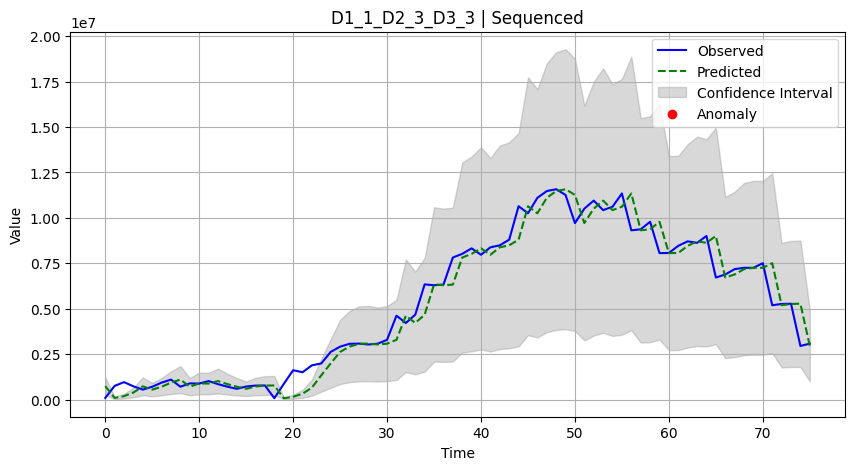

Inserted anomalies:  [2779] ['higher value']
Detected anomalies:  [] []


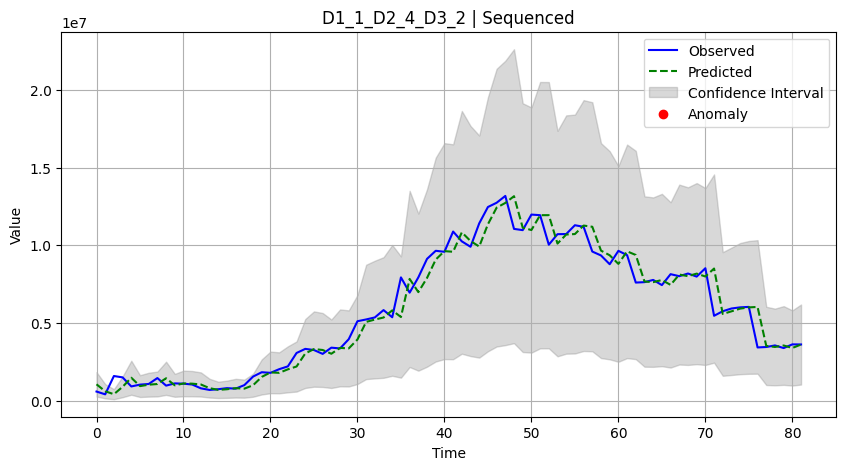

Inserted anomalies:  [976] ['extremely higher value']
Detected anomalies:  [727 753 954 976 981 1020] ['too high( 135.0% )-patchy', 'too high( 184.0% )-patchy', 'too low( 160.0% )-patchy', 'too high( 18886.0% )-isolated', 'too low( 192.0% )-patchy', 'too low( 172.0% )-patchy']


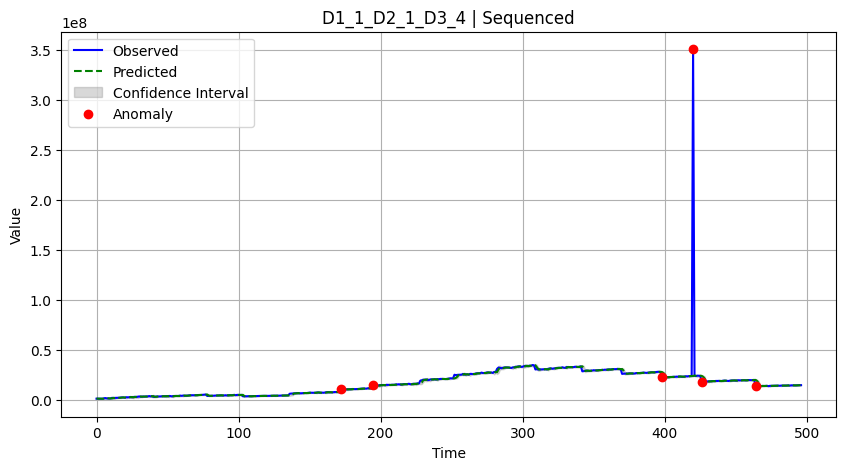

Inserted anomalies:  [1810] ['extremely higher value']
Detected anomalies:  [1810] ['too high( 572.0% )-isolated']


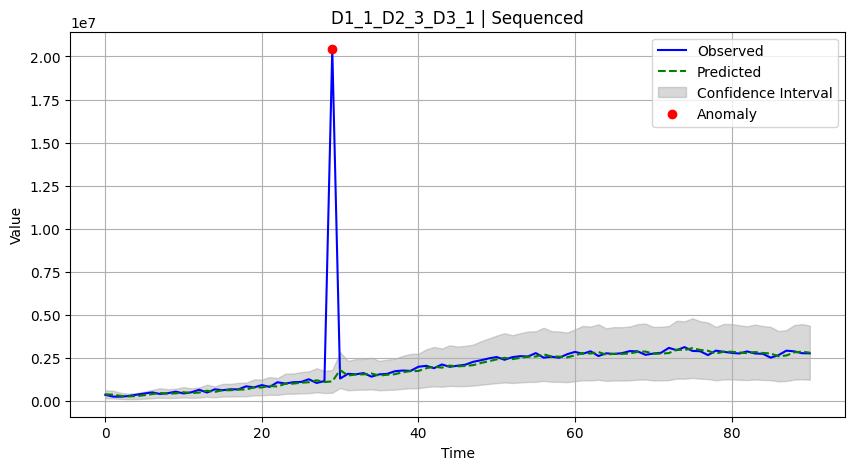

Inserted anomalies:  [2751] ['higher value']
Detected anomalies:  [] []


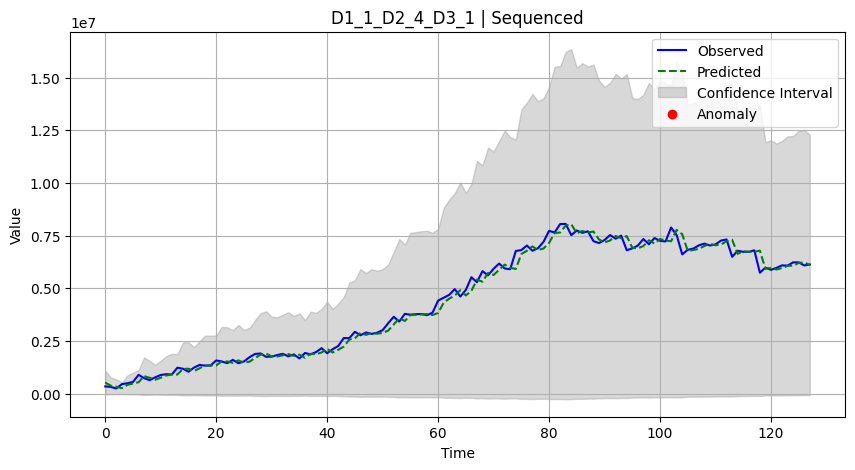

Inserted anomalies:  [1164] ['higher value']
Detected anomalies:  [] []


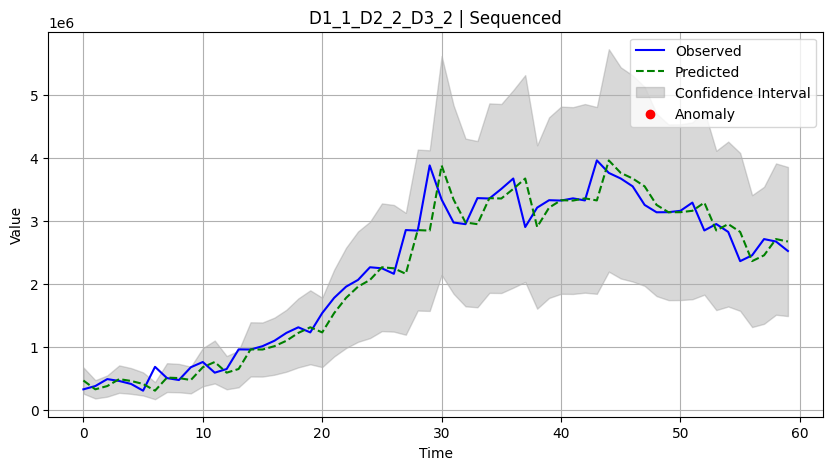

Inserted anomalies:  [3656] ['higher value']
Detected anomalies:  [] []


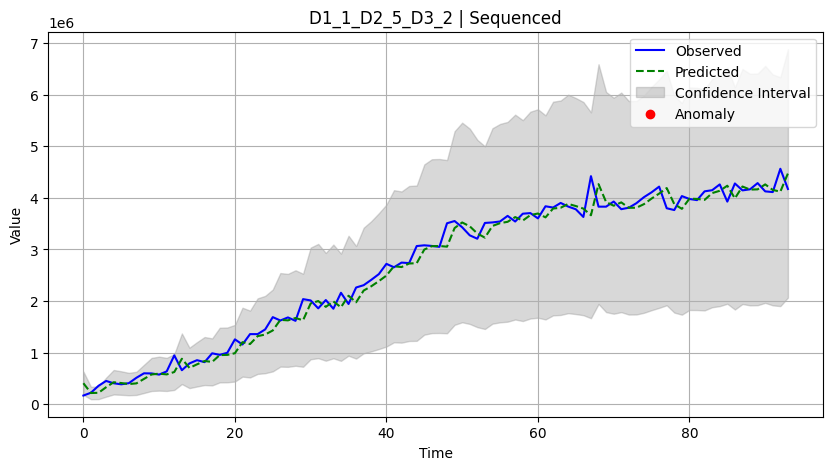

Inserted anomalies:  [3737] ['higher value']
Detected anomalies:  [] []


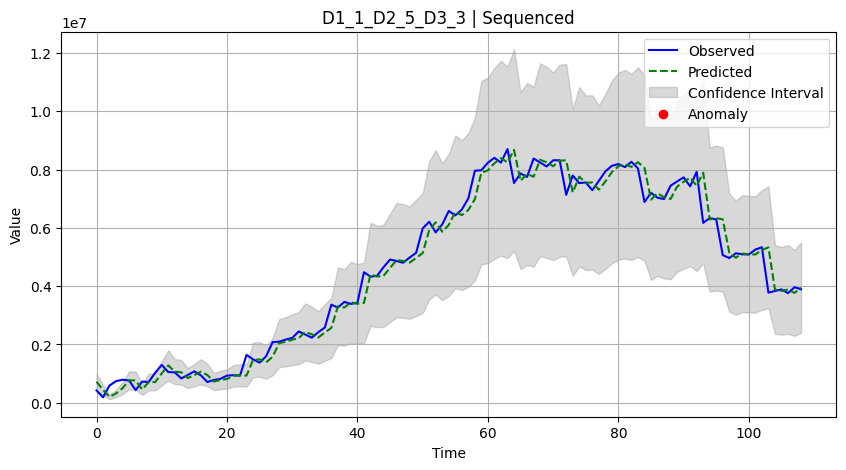

Inserted anomalies:  [1225] ['higher value']
Detected anomalies:  [1197] ['too high( 39.0% )-isolated']


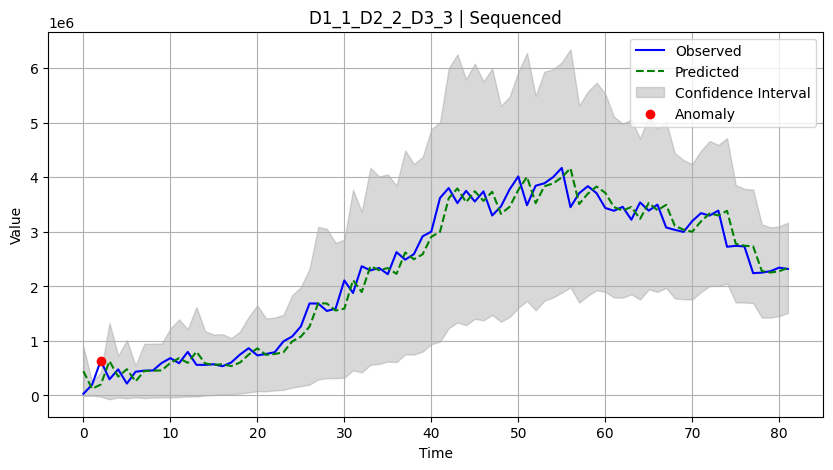

Inserted anomalies:  [535] ['extremely higher value']
Detected anomalies:  [535] ['too high( 6241.0% )-isolated']


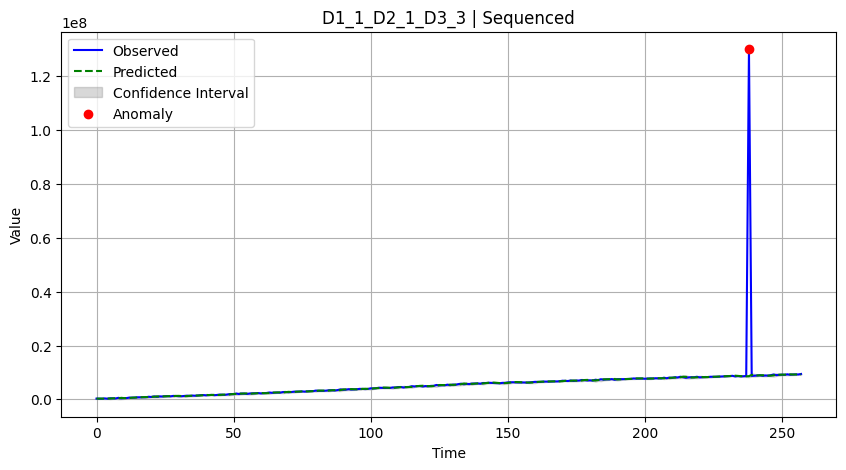

Inserted anomalies:  [2915] ['higher value']
Detected anomalies:  [] []


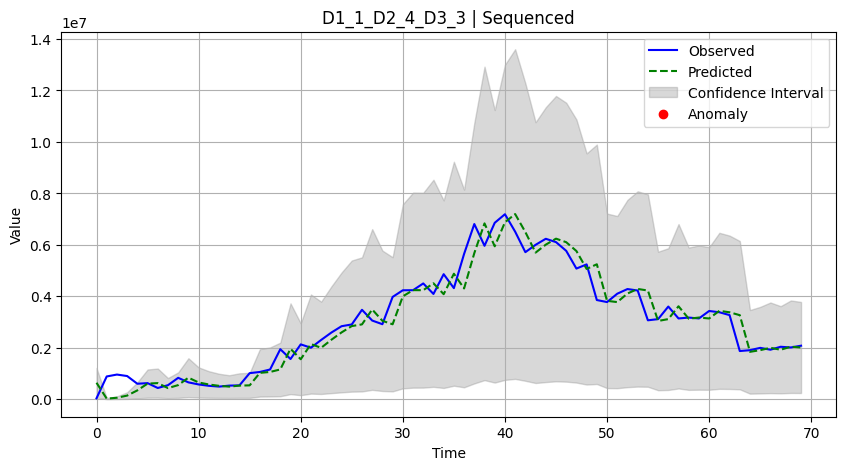

Inserted anomalies:  [3564] ['higher value']
Detected anomalies:  [3220 3464 3494 3518 3553] ['too high( 108.0% )-patchy', 'too low( 167.0% )-patchy', 'too low( 270.0% )-patchy', 'too low( 135.0% )-patchy', 'too low( 242.0% )-patchy']


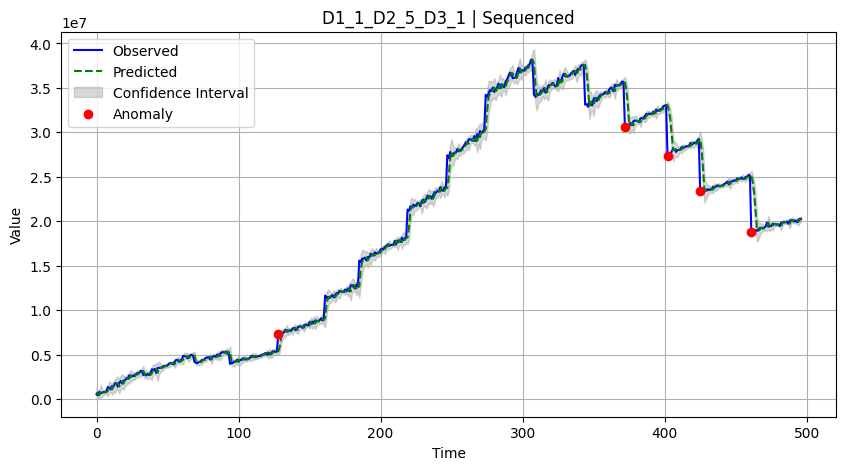

Inserted anomalies:  [1565] ['extremely higher value']
Detected anomalies:  [1364 1395 1436 1455 1489 1550 1565 1577 1614 1647 1681 1712 1739] ['too low( 102.0% )-patchy', 'too high( 150.0% )-patchy', 'too high( 119.0% )-patchy', 'too high( 86.0% )-patchy', 'too high( 90.0% )-patchy', 'too high( 129.0% )-patchy', 'too high( 4750.0% )-isolated', 'too low( 132.0% )-patchy', 'too low( 118.0% )-patchy', 'too low( 234.0% )-patchy', 'too low( 295.0% )-patchy', 'too low( 204.0% )-patchy', 'too low( 318.0% )-patchy']


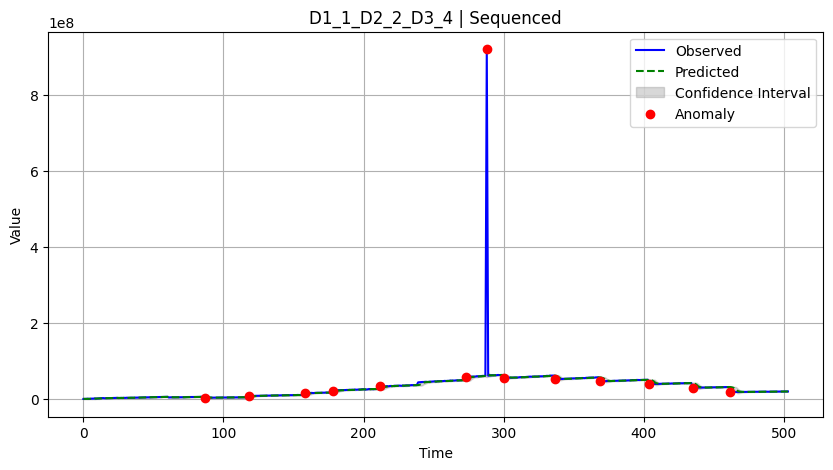

Inserted anomalies:  [1912] ['lower value']
Detected anomalies:  [] []


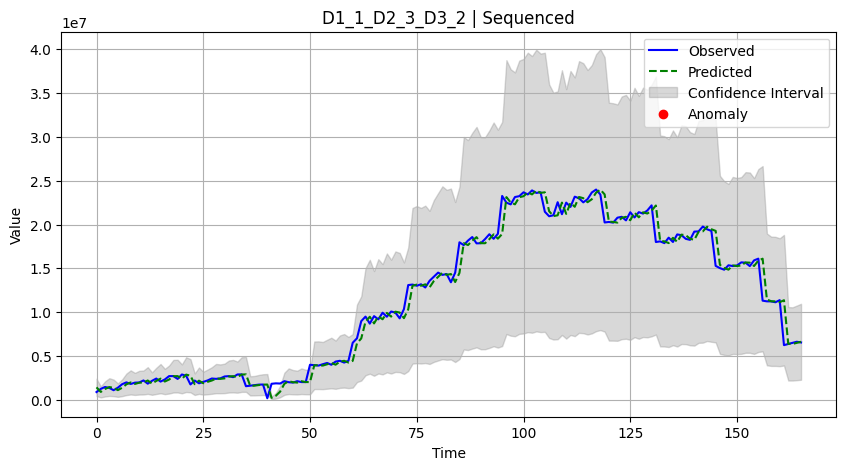

Inserted anomalies:  [3914] ['extremely higher value']
Detected anomalies:  [3914] ['too high( 4739.0% )-isolated']


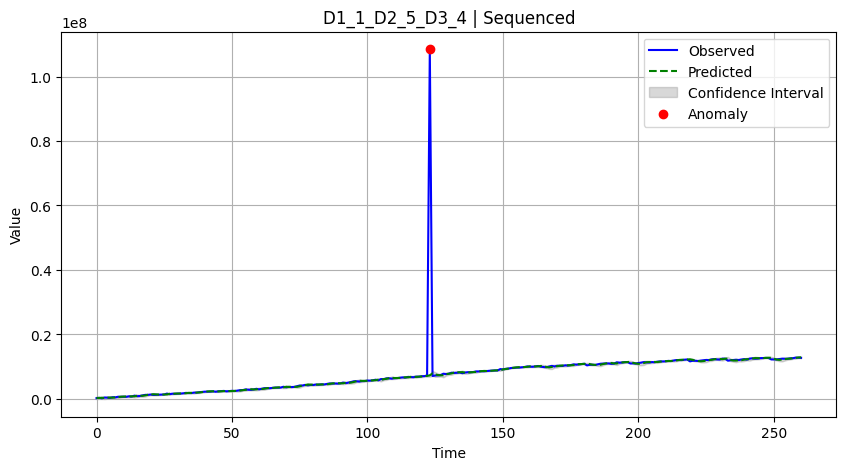

Inserted anomalies:  [2566] ['higher value']
Detected anomalies:  [2202 2234 2269 2332 2430 2462 2488 2535 2572 2608] ['too low( 99.0% )-patchy', 'too high( 255.0% )-patchy', 'too high( 311.0% )-patchy', 'too high( 98.0% )-patchy', 'too low( 80.0% )-patchy', 'too low( 102.0% )-patchy', 'too low( 209.0% )-patchy', 'too low( 327.0% )-patchy', 'too low( 191.0% )-patchy', 'too low( 360.0% )-patchy']


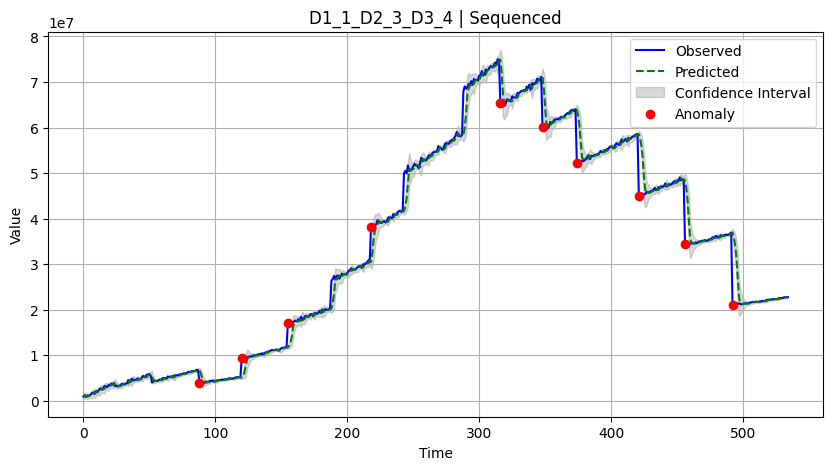

Inserted anomalies:  [1055] ['higher value']
Detected anomalies:  [1055] ['too high( 58.0% )-isolated']


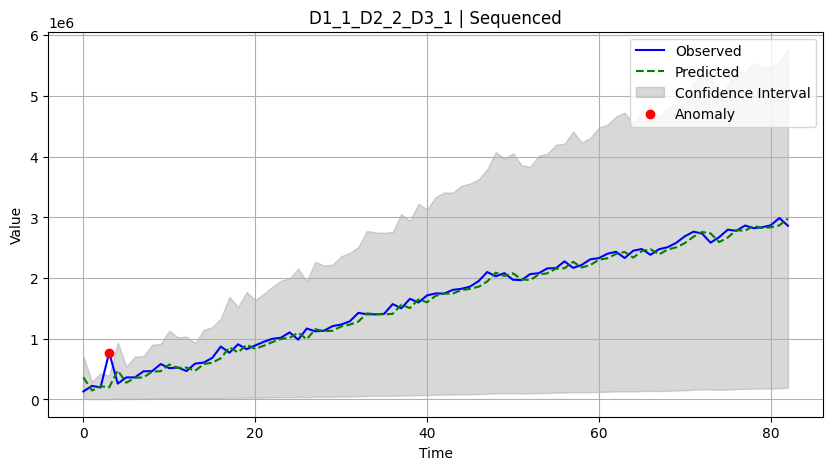

Inserted anomalies:  [72] ['higher value']
Detected anomalies:  [] []


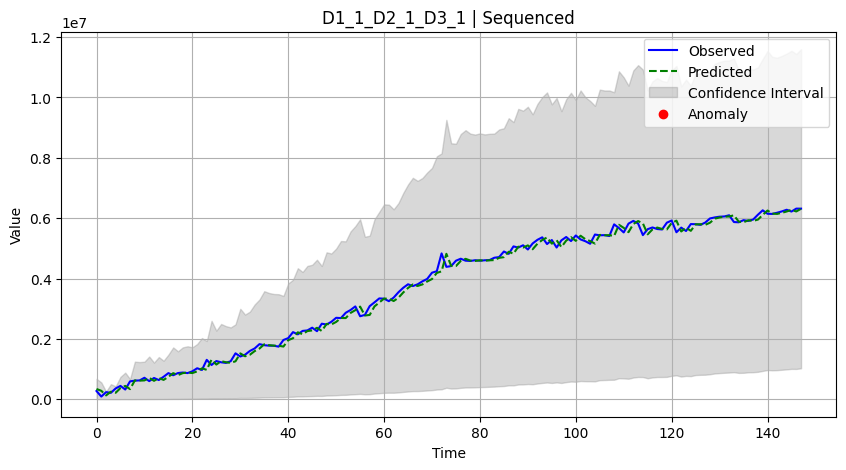

Inserted anomalies:  [173] ['lower value']
Detected anomalies:  [173] ['too low( 60.0% )-isolated']


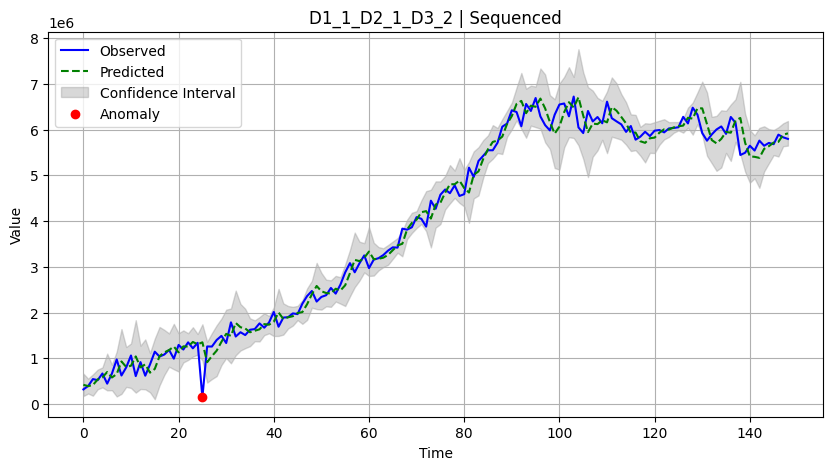

Inserted anomalies:  [2975] ['higher value']
Detected anomalies:  [] []


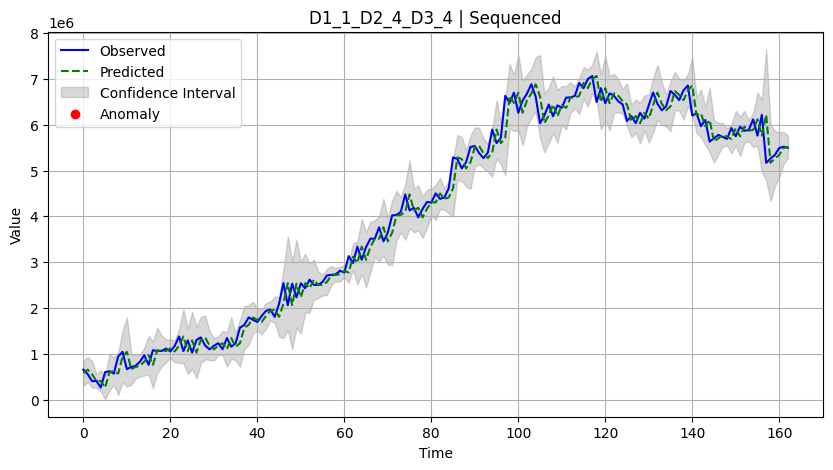

In [8]:
The_only_model.inspect_performance_visually()